Hier werden die Ergebnisse eingelesen und ausgewertet

In [1]:
#Import der notwendigen Bibliotheken, Installation mit pip bereits erfolgt

import yfinance as yf
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import csv
from scipy.optimize import minimize
import math
import random
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import linkage, dendrogram
import riskfolio as rp
from sklearn.covariance import LedoitWolf
from scipy.spatial.distance import squareform
from riskfolio import HCPortfolio as hc

In [2]:
def gesamt_return(returns):

    total = np.cumprod(1 + returns)
    
    return total

In [3]:
def portfolio_return (returns):
    
    pf_return = returns.mean()
    
    return pf_return

In [4]:
def portfolio_variance (returns):
    
    pf_var = np.var(returns)
    
    return pf_var

In [5]:
def portfolio_volatility (returns):
    variance = portfolio_variance(returns)
    volatility = np.sqrt(variance)
    
    return volatility

In [6]:
def sharpe_ratio (returns):
    pf_return = portfolio_return (returns)
    volatility = portfolio_volatility (returns)
    zins_risikofrei = 0
    
    sharpe_ratio = (pf_return - zins_risikofrei) / volatility
    
    return sharpe_ratio

In [7]:
def sharpe_ratio_one (gewichte, returns):
    pf_return = portfolio_return (gewichte, returns)
    volatility = portfolio_volatility (gewichte, returns)
    zins_risikofrei = 0.01
    
    sharpe_ratio = (pf_return - zins_risikofrei) / volatility
    
    return sharpe_ratio

In [8]:
def sharpe_ratio_two (gewichte, returns):
    pf_return = portfolio_return (gewichte, returns)
    volatility = portfolio_volatility (gewichte, returns)
    zins_risikofrei = 0.02
    
    sharpe_ratio = (pf_return - zins_risikofrei) / volatility
    
    return sharpe_ratio

In [9]:
def sortino_ratio (returns): 
    
    zins_risikofrei = 0
        
    temp = (np.minimum(0, returns - zins_risikofrei))**2
    temp = np.mean(temp)
    
    downside_dev = np.sqrt(temp)
    
    pf_return = portfolio_return (returns)
    
    sortino_ratio = (pf_return - zins_risikofrei) / downside_dev
    
    return sortino_ratio

In [10]:
def sortino_ratio_one (gewichte, returns):    
    daily_returns = []
    zins_risikofrei = 0.01
    
    for index, zeile in returns.iterrows():
        daily_returns.append(np.dot(gewichte, zeile))
    
    daily_returns = np.array(daily_returns)
        
    temp = np.minimum(0, daily_returns - zins_risikofrei)**2
    temp = np.mean(temp)
    
    downside_dev = np.sqrt(temp)
    
    pf_return = portfolio_return (gewichte, returns)
    
    sortino_ratio = (pf_return - zins_risikofrei) / downside_dev
    
    return sortino_ratio

In [11]:
def sortino_ratio_two (gewichte, returns):    
    daily_returns = []
    zins_risikofrei = 0.02
    
    for index, zeile in returns.iterrows():
        daily_returns.append(np.dot(gewichte, zeile))
    
    daily_returns = np.array(daily_returns)
        
    temp = np.minimum(0, daily_returns - zins_risikofrei)**2
    temp = np.mean(temp)
    
    downside_dev = np.sqrt(temp)
    
    pf_return = portfolio_return (gewichte, returns)
    
    sortino_ratio = (pf_return - zins_risikofrei) / downside_dev
    
    return sortino_ratio

In [12]:
def maximum_drawdown (returns):
    
    returns_kumuliert = (1 + returns).cumprod()
    hochpunkte = returns_kumuliert.cummax()
    
    drawdowns = (returns_kumuliert - hochpunkte) / hochpunkte
    max_drawdown = drawdowns.min()
    
    #print(drawdowns)
    return max_drawdown

In [13]:
def calmar_ratio (returns):
    total_return = (1 + returns).prod() - 1
    annualized_return = (1 + total_return) ** (252 / len(returns)) - 1
    max_drawdown = maximum_drawdown(returns)
    
    calmar_ratio = annualized_return / (-max_drawdown)
    
    return calmar_ratio

In [14]:
def calmar_ratio_total (returns):
    total_return = (1 + returns).prod() - 1
    
    max_drawdown = maximum_drawdown(returns)
    calmar_ratio_gesamt = total_return / (-max_drawdown)
    
    return calmar_ratio_gesamt

In [15]:
def value_at_risk_func(returns):
    sorted_daily_returns = returns.sort_values(ascending = True)
    value_at_risk = np.percentile(sorted_daily_returns, 100*0.05)
    return value_at_risk

In [16]:
#https://github.com/malctaylor15/VaR-and-Expected-Shortfall-Python/blob/master/Expected%20Shortfall%20and%20Value%20at%20Risk.ipynb

def expected_shortfall(returns):
    sorted_daily_returns = returns.sort_values(ascending = True)
    value_at_risk = value_at_risk_func(returns)
    
    expected_shortfall = sorted_daily_returns[sorted_daily_returns <= value_at_risk].mean()
    
    return expected_shortfall

## Auswertung S&P 500 Voll

In [17]:
#Bearbeitete SP500-Daten (Gesamtbestand)

df_SP500 = pd.read_csv(
    'renditensp500_neu_f.csv',
    sep=',',
    encoding='utf-8',
    index_col=0,
    decimal = '.',
    low_memory=False,
    parse_dates=['Date'],
    dayfirst=True
)

In [18]:
df_SP500.info

<bound method DataFrame.info of             Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0     2006-06-01          0.012900          0.010492                 0.011293   
1     2006-06-02          0.001590          0.000522                 0.001549   
2     2006-06-05         -0.019401         -0.011919                -0.015252   
3     2006-06-06         -0.002777          0.003684                -0.002977   
4     2006-06-07         -0.005689         -0.000060                -0.001034   
...          ...               ...               ...                      ...   
4775  2025-05-23         -0.003974          0.001687                -0.000343   
4776  2025-05-27          0.018501          0.008048                 0.007768   
4777  2025-05-28         -0.008744         -0.006262                -0.006605   
4778  2025-05-29          0.003698          0.002826                 0.001825   
4779  2025-05-30         -0.000446          0.005156                 0.006814

In [19]:
df_SP500.head()

Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0  2006-06-01          0.012900          0.010492                 0.011293   
1  2006-06-02          0.001590          0.000522                 0.001549   
2  2006-06-05         -0.019401         -0.011919                -0.015252   
3  2006-06-06         -0.002777          0.003684                -0.002977   
4  2006-06-07         -0.005689         -0.000060                -0.001034   

   Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
0            0.012190                 0.012325  0.011644  0.011080  
1            0.001516                 0.001464  0.000663  0.004289  
2           -0.017715                -0.017951 -0.015949 -0.016100  
3           -0.002189                -0.002313 -0.001144 -0.001374  
4           -0.003947                -0.004079 -0.002087 -0.001610

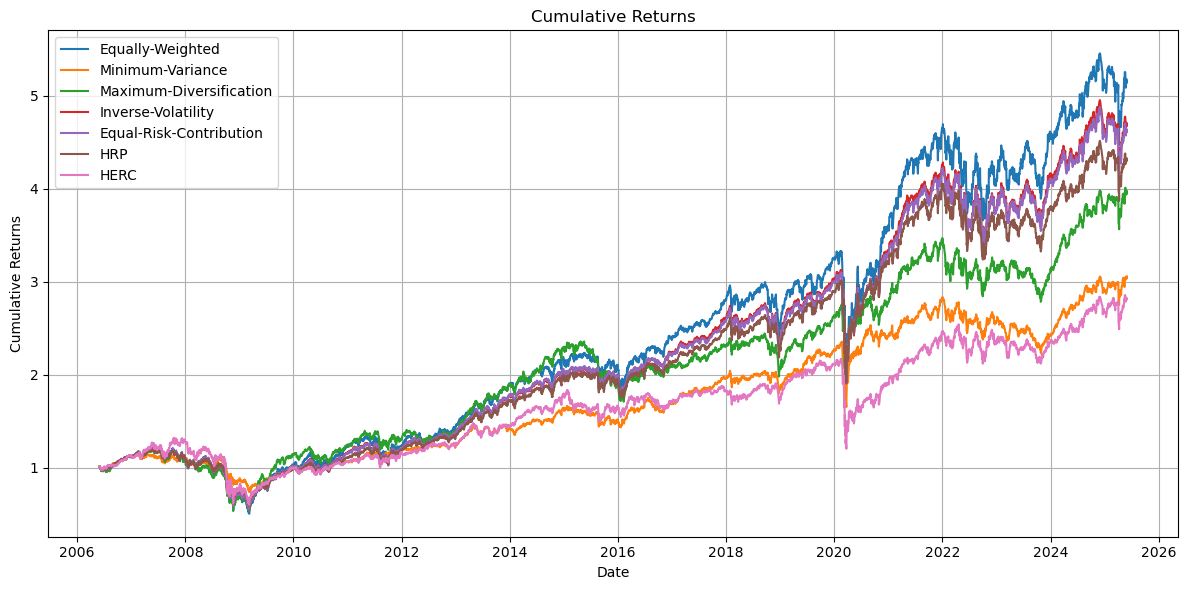

In [20]:
df_SP500["Date"] = pd.to_datetime(df_SP500["Date"])

#Date-Spalte als Index setzen
df_SP500 = df_SP500.set_index("Date")

#Kumulierte Rendite berechnen (angenommen tägliche Returns)
#(1 + r).cumprod() - 1 ergibt den Gesamtzuwachs in Prozent
kumulative_returns = gesamt_return(df_SP500)

#Plot
plt.figure(figsize=(12,6))
plt.plot(kumulative_returns)
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend(kumulative_returns.columns, loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
letzte_returns = kumulative_returns.iloc[-1]
print(letzte_returns)

Equally-Weighted           5.154869
Minimum-Variance           3.057742
Maximum-Diversification    3.975994
Inverse-Volatility         4.696276
Equal-Risk-Contribution    4.632532
HRP                        4.323358
HERC                       2.818035
Name: 2025-05-30 00:00:00, dtype: float64


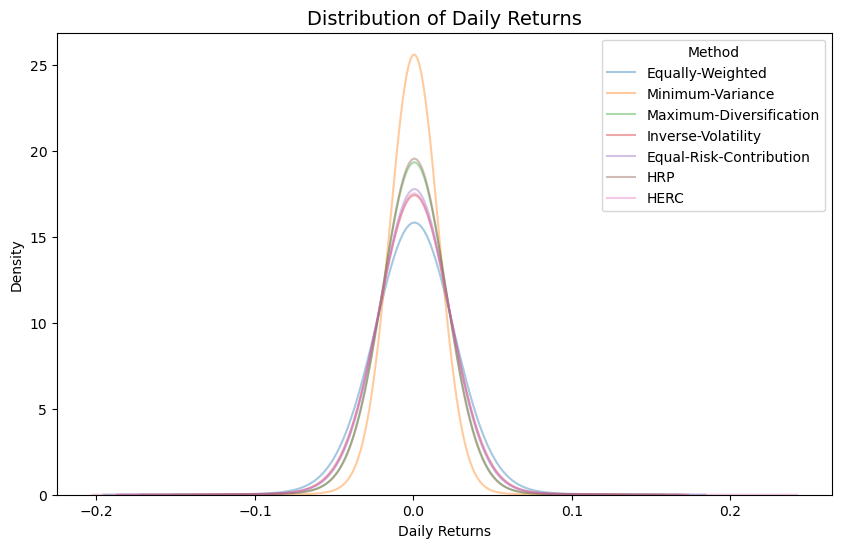

In [22]:
plt.figure(figsize=(10, 6))
for col in df_SP500.columns:
    sb.kdeplot(df_SP500[col], label=col, fill=False, alpha=0.4, bw_adjust=9)

plt.title("Distribution of Daily Returns", fontsize=14)
plt.xlabel("Daily Returns")
plt.ylabel("Density")
plt.legend(title="Method")
plt.show()

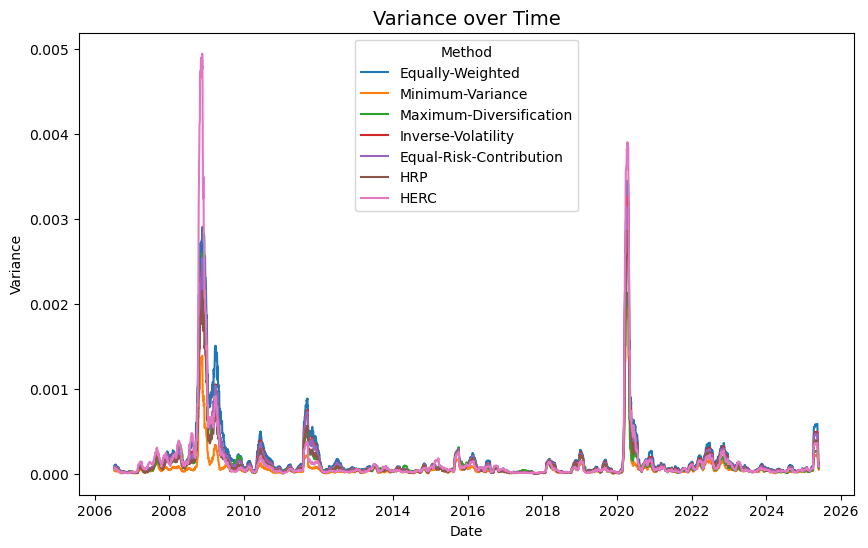

In [23]:
rollierende_varianz = df_SP500.rolling(window=30).var()

plt.figure(figsize=(10, 6))
for col in rollierende_varianz.columns:
    plt.plot(rollierende_varianz.index, rollierende_varianz[col], label=col)

plt.title("Variance over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Variance")
plt.legend(title="Method")
plt.show()

In [24]:
#Letzten Wert jedes Jahres extrahieren
df_kum_endwerte = kumulative_returns.resample('Y').last()

#Jahr als Spalte
df_kum_endwerte.index = df_kum_endwerte.index.year
df_kum_endwerte.index.name = "Year"

df_kum_endwerte

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Year                                                                
2006          1.114974          1.128056                 1.118876   
2007          1.109311          1.087274                 1.070145   
2008          0.709924          0.879072                 0.690616   
2009          1.019266          0.999282                 1.129896   
2010          1.220448          1.066812                 1.243388   
2011          1.224828          1.201825                 1.297092   
2012          1.421015          1.225808                 1.375172   
2013          1.909258          1.426973                 1.901692   
2014          2.157151          1.616419                 2.265723   
2015          2.074005          1.496521                 1.888772   
2016          2.373687          1.681839                 2.082605   
2017          2.793787          1.959810                 2.301614   
2018          2.550594          1.873499                 2.077459   
2019          3.252948          2.275725                 2.641464   
2020          3.609257          2.426663                 2.788430   
2021          4.650769          2.834649                 3.469906   
2022          4.084372          2.567419                 3.120516   
2023          4.601489          2.425870                 3.104803   
2024          5.102796          2.896136                 3.783791   
2025          5.154869          3.057742                 3.975994   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Year                                                                   
2006            1.120833                 1.121448  1.122735  1.126369  
2007            1.110356                 1.112088  1.109959  1.285532  
2008            0.739343                 0.738160  0.766348  0.781716  
2009            0.992526                 0.992207  0.977342  0.989805  
2010            1.156315                 1.148515  1.105186  1.060618  
2011            1.193294                 1.193937  1.185967  1.158987  
2012            1.356702                 1.356358  1.323792  1.240401  
2013            1.783704                 1.791785  1.729774  1.454694  
2014            2.019347                 2.031478  1.965494  1.756847  
2015            1.969262                 1.967293  1.924451  1.644842  
2016            2.211479                 2.199675  2.114698  1.705957  
2017            2.600347                 2.567803  2.480048  1.831670  
2018            2.387297                 2.373784  2.304241  1.756494  
2019            3.033003                 3.003528  2.900881  2.117869  
2020            3.345221                 3.313102  3.233528  1.919864  
2021            4.258220                 4.212242  4.055571  2.463518  
2022            3.779634                 3.772216  3.597182  2.359126  
2023            4.157652                 4.100710  3.804781  2.348238  
2024            4.629226                 4.574540  4.234312  2.668979  
2025            4.696276                 4.632532  4.323358  2.818035

In [25]:
#jährliche kumulierte Rendite berechnen
jährlich_kum_returns = (1 + df_SP500).resample('Y').prod() - 1

#Jahr als Spalte
jährlich_kum_returns.index = jährlich_kum_returns.index.year
jährlich_kum_returns.index.name = "Year"

jährlich_kum_returns

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Year                                                                
2006          0.114974          0.128056                 0.118876   
2007         -0.005079         -0.036152                -0.043553   
2008         -0.360032         -0.191490                -0.354652   
2009          0.435741          0.136746                 0.636071   
2010          0.197379          0.067578                 0.100444   
2011          0.003589          0.126558                 0.043192   
2012          0.160175          0.019955                 0.060196   
2013          0.343587          0.164109                 0.382876   
2014          0.129837          0.132760                 0.191425   
2015         -0.038544         -0.074175                -0.166371   
2016          0.144494          0.123832                 0.102624   
2017          0.176982          0.165278                 0.105161   
2018         -0.087048         -0.044040                -0.097390   
2019          0.275369          0.214692                 0.271488   
2020          0.109534          0.066326                 0.055638   
2021          0.288567          0.168126                 0.244394   
2022         -0.121786         -0.094273                -0.100692   
2023          0.126608         -0.055133                -0.005035   
2024          0.108945          0.193855                 0.218690   
2025          0.010205          0.055801                 0.050796   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Year                                                                   
2006            0.120833                 0.121448  0.122735  0.126369  
2007           -0.009348                -0.008346 -0.011380  0.141305  
2008           -0.334139                -0.336239 -0.309571 -0.391912  
2009            0.342444                 0.344162  0.275324  0.266195  
2010            0.165023                 0.157536  0.130808  0.071542  
2011            0.031980                 0.039548  0.073092  0.092747  
2012            0.136938                 0.136039  0.116213  0.070245  
2013            0.314735                 0.321026  0.306681  0.172762  
2014            0.132109                 0.133774  0.136272  0.207708  
2015           -0.024803                -0.031595 -0.020882 -0.063753  
2016            0.122999                 0.118123  0.098857  0.037155  
2017            0.175840                 0.167356  0.172767  0.073690  
2018           -0.081931                -0.075558 -0.070889 -0.041043  
2019            0.270476                 0.265291  0.258931  0.205737  
2020            0.102940                 0.103070  0.114671 -0.093492  
2021            0.272927                 0.271389  0.254225  0.283173  
2022           -0.112391                -0.104464 -0.113027 -0.042375  
2023            0.100015                 0.087083  0.057711 -0.004615  
2024            0.113423                 0.115548  0.112893  0.136588  
2025            0.014484                 0.012677  0.021030  0.055847

In [26]:
from IPython.display import display, HTML

display(HTML(jährlich_kum_returns.to_html()))

In [27]:
reorganisiert = jährlich_kum_returns.reset_index().melt(id_vars="Year", var_name="Strategy", value_name="Returns")
reorganisiert.head()

Year          Strategy   Returns
0  2006  Equally-Weighted  0.114974
1  2007  Equally-Weighted -0.005079
2  2008  Equally-Weighted -0.360032
3  2009  Equally-Weighted  0.435741
4  2010  Equally-Weighted  0.197379

In [28]:
import plotly.express as px

fig = px.bar(reorganisiert, 
             x="Year", y="Returns", color="Strategy", 
             barmode="group",
             text="Returns",
             title="Yearly Cumulative Returns",
             color_discrete_sequence=px.colors.qualitative.Vivid)

fig.update_traces(texttemplate='%{text:.1%}', textposition='outside')
fig.update_layout(yaxis_tickformat='.0%', xaxis={'type': 'category'})
fig.show()

In [29]:
#jährliche vola

jährliche_vola = (df_SP500.groupby(df_SP500.index.year).std()
    .apply(lambda x: x * np.sqrt(252))
    * 100
)

jährliche_vola

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         11.069689          7.281129                 9.985011   
2007         16.823788         10.984753                14.425853   
2008         45.380090         26.207083                39.230666   
2009         35.290802         15.682006                26.953304   
2010         20.013835         10.415019                15.077992   
2011         25.658320         12.673398                19.309946   
2012         13.816694          7.606596                11.508512   
2013         12.025781          9.179602                11.288063   
2014         11.649169          8.557950                12.000965   
2015         15.535796         12.440032                15.999849   
2016         14.708428         10.320716                13.634041   
2017          7.208179          5.751973                 7.631474   
2018         15.502950         11.373078                13.131079   
2019         12.481336          8.598493                 9.993179   
2020         39.146423         27.430775                29.583285   
2021         13.759528         10.044294                10.974109   
2022         23.090694         15.210070                17.884910   
2023         14.245057         10.116913                11.049305   
2024         11.451050          7.731529                 8.742765   
2025         23.590937         15.035248                16.489347   

      Inverse-Volatility  Equal-Risk-Contribution        HRP       HERC  
Date                                                                     
2006           10.018112                10.081097   9.081002   8.879742  
2007           16.062842                15.850926  14.531712  18.475776  
2008           40.700314                40.292778  36.021217  50.075151  
2009           29.007523                28.724138  23.996562  25.566109  
2010           17.768578                17.143164  15.094846  13.608629  
2011           23.238183                22.773680  19.804559  16.232996  
2012           12.122645                11.877858  10.246012   8.951245  
2013           11.377001                11.227575  10.630125  11.622611  
2014           11.095576                11.085797  10.578689  10.224155  
2015           15.062248                15.030560  14.564459  15.947259  
2016           13.506494                13.365061  12.553818  13.430552  
2017            6.640429                 6.486021   6.238058   6.511388  
2018           14.797002                14.561817  14.089798  12.590085  
2019           11.509652                10.910846  10.257050   9.537836  
2020           37.122483                36.164424  33.985329  39.345504  
2021           12.595176                11.972600  11.251363  11.553562  
2022           21.455770                20.679513  19.435874  19.068757  
2023           13.186558                12.684460  11.739375  12.094978  
2024           10.688584                10.302742   9.669897   9.569246  
2025           21.768611                21.274601  19.627613  19.178460

<Figure size 1000x600 with 0 Axes>

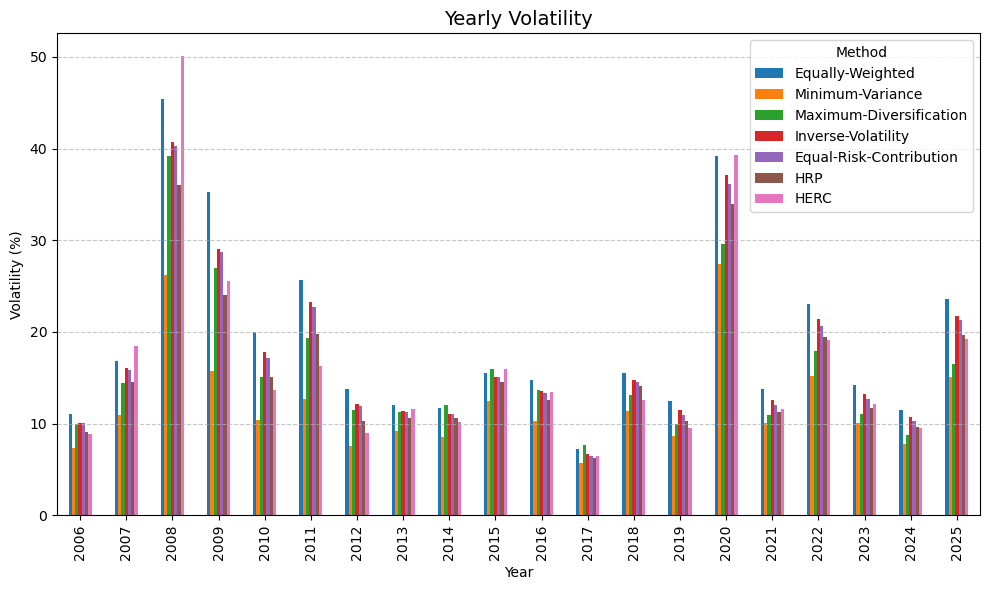

In [30]:
plt.figure(figsize=(10, 6))
jährliche_vola.plot(kind="bar", figsize=(10, 6))

plt.title("Yearly Volatility", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Volatility (%)")
plt.legend(title="Method")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

#### Sharpe Ratio

In [31]:
df_SP500.index = pd.to_datetime(df_SP500.index)
sharpe_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(lambda y: sharpe_ratio(y) * np.sqrt(252)))

In [32]:
sharpe_jahresweise

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          1.735345          2.864783                 1.972380   
2007          0.053772         -0.282281                -0.238352   
2008         -0.754120         -0.679083                -0.917286   
2009          1.203315          0.897437                 1.966495   
2010          1.002074          0.681263                 0.711577   
2011          0.142605          1.005740                 0.316077   
2012          1.155302          0.300369                 0.570508   
2013          2.522322          1.705027                 2.935706   
2014          1.108489          1.502598                 1.522773   
2015         -0.175824         -0.558405                -1.059078   
2016          0.993231          1.185194                 0.786120   
2017          2.310931          2.704721                 1.356465   
2018         -0.513253         -0.341416                -0.719172   
2019          2.016029          2.310218                 2.459457   
2020          0.462482          0.371352                 0.331852   
2021          1.915870          1.600837                 2.052030   
2022         -0.450430         -0.578746                -0.507443   
2023          0.916477         -0.515580                 0.009030   
2024          0.962259          2.335714                 2.311187   
2025          0.223548          0.971835                 0.828313   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006            1.995943                 1.993397  2.224045  2.334636  
2007            0.021582                 0.026160 -0.006505  0.812435  
2008           -0.793420                -0.813350 -0.846209 -0.741587  
2009            1.162393                 1.175502  1.135661  1.052957  
2010            0.950285                 0.940903  0.891603  0.576800  
2011            0.252192                 0.284787  0.456165  0.628774  
2012            1.130017                 1.144104  1.135117  0.810749  
2013            2.468074                 2.542074  2.575774  1.432281  
2014            1.176259                 1.190483  1.263220  1.901231  
2015           -0.091766                -0.138862 -0.072357 -0.333948  
2016            0.928301                 0.904047  0.815303  0.339436  
2017            2.487887                 2.433158  2.601990  1.131159  
2018           -0.506976                -0.469765 -0.454328 -0.271813  
2019            2.142597                 2.216440  2.301690  2.013810  
2020            0.450749                 0.453369  0.490331 -0.048559  
2021            1.983581                 2.070222  2.074342  2.221103  
2022           -0.451818                -0.433410 -0.523619 -0.133273  
2023            0.796031                 0.728238  0.541351  0.021760  
2024            1.060798                 1.115145  1.156885  1.388752  
2025            0.271910                 0.252477  0.360742  0.799303

In [33]:
#Durchschnitt
sharpe_durchschnitt = sharpe_jahresweise.mean(axis=1)

sharpe_durchschnitt = sharpe_durchschnitt.to_frame(name="Sharpe_Mittelwert")

sharpe_durchschnitt.info

<bound method DataFrame.info of       Sharpe_Mittelwert
Date                   
2006           2.160076
2007           0.055259
2008          -0.792151
2009           1.227680
2010           0.822072
2011           0.440906
2012           0.892309
2013           2.311608
2014           1.380722
2015          -0.347177
2016           0.850233
2017           2.146616
2018          -0.468103
2019           2.208606
2020           0.358797
2021           1.988283
2022          -0.439820
2023           0.356758
2024           1.475820
2025           0.529732>

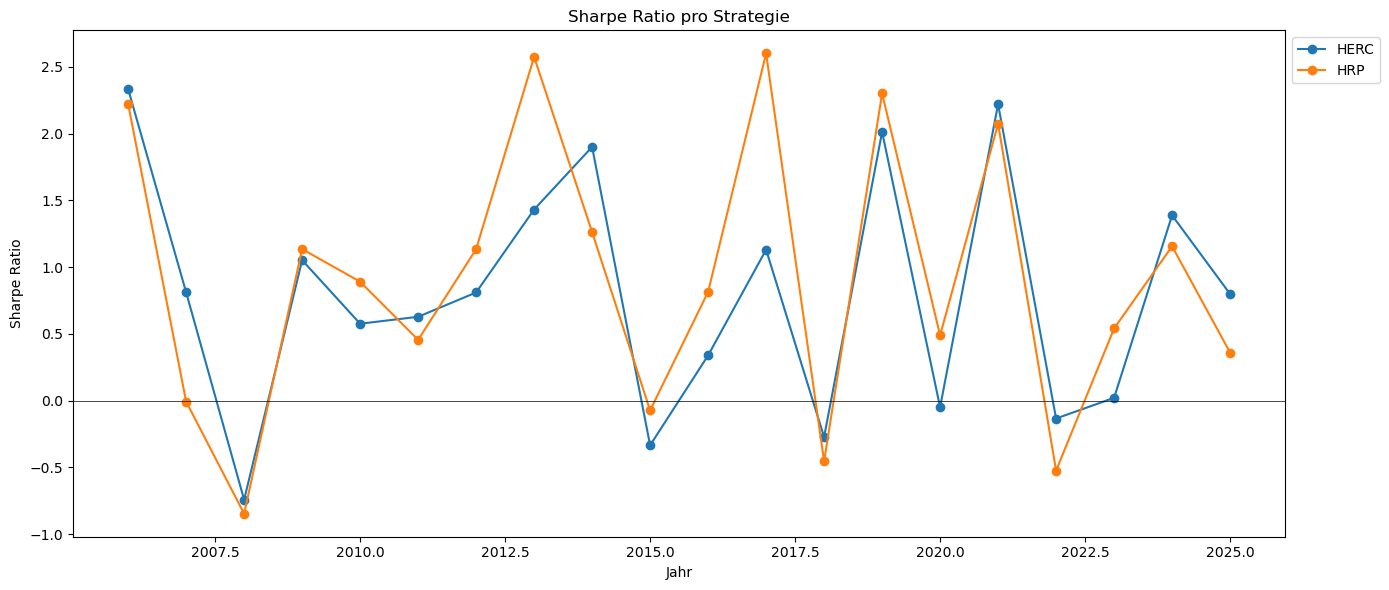

In [34]:
#Plotten der SR
strategien = sharpe_jahresweise.columns
years = sharpe_jahresweise.index

plt.figure(figsize=(14,6))

strategie = "HERC"
plt.plot(years, sharpe_jahresweise[strategie], label=strategie, marker='o')

strategie = "HRP"
plt.plot(years, sharpe_jahresweise[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  
plt.xlabel("Jahr")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

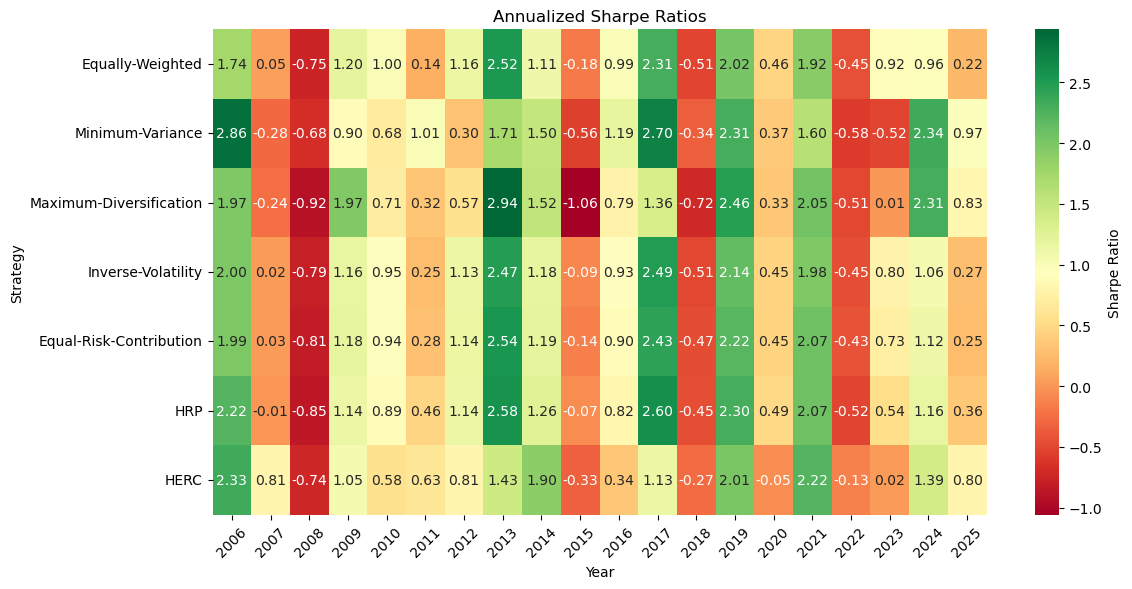

In [35]:
plt.figure(figsize=(12,6))
sb.heatmap(sharpe_jahresweise.T,        
            annot=True,                  
            fmt=".2f",                   
            cmap="RdYlGn",               
            cbar_kws={'label': 'Sharpe Ratio'})  

plt.title("Annualized Sharpe Ratios")
plt.xlabel("Year")
plt.ylabel("Strategy")
plt.yticks(rotation=0)  
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [36]:
#Simulation mit synthetischen Werten

np.random.seed(42)

#Simulation: 20 Jahre, 252 Handelstage pro Jahr
years = 20
days_per_year = 252
mu_daily = 0.0005       
sigma_daily = 0.01      

#Simulierte tägliche Renditen (normalverteilt)
daily_returns = np.random.normal(loc=mu_daily, scale=sigma_daily, size=(days_per_year*years,))

#Datum-Index erstellen
dates = pd.date_range(start="2000-01-01", periods=days_per_year*years, freq='B')
df_sim = pd.DataFrame(daily_returns, index=dates, columns=['Strategy'])

#Funktion für annualisierten Sharpe Ratio
def sharpe_annual(returns_daily):
    return (returns_daily.mean() / returns_daily.std()) * np.sqrt(days_per_year)

#Sharpe Ratios pro Jahr berechnen
sharpe_by_year = df_sim.groupby(df_sim.index.year).apply(lambda x: x.apply(sharpe_annual))

print(sharpe_by_year)

      Strategy
2000  0.938821
2001  0.686188
2002  0.254476
2003  3.547887
2004  1.809797
2005  2.077011
2006  1.241718
2007  0.797057
2008  1.363644
2009  0.511714
2010  2.034882
2011 -0.234316
2012  0.727365
2013  1.306639
2014 -0.508489
2015  0.455300
2016 -1.627256
2017  1.034871
2018  0.593904
2019  2.021202


In [37]:
#Funktion für annualisierten Sharpe Ratio
def sharpe_annual(returns_daily):
    mean_daily = returns_daily.mean()
    std_daily = returns_daily.std()
    return (mean_daily / std_daily) * np.sqrt(252)  # 252 Handelstage

#Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
annualized_sharpe = df_SP500.apply(sharpe_annual)

print(annualized_sharpe)

Equally-Weighted           0.507720
Minimum-Variance           0.507011
Maximum-Diversification    0.499950
Inverse-Volatility         0.513088
Equal-Risk-Contribution    0.515651
HRP                        0.527955
HERC                       0.374848
dtype: float64


In [38]:
#Funktion für annualisierten Sharpe Ratio
def sharpe_total(returns_daily):
    mean_daily = returns_daily.mean()
    std_daily = returns_daily.std()
    return (mean_daily / std_daily) * np.sqrt(4780)  #4780 Handelstage

#Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
total_sharpe = df_SP500.apply(sharpe_total)

print(total_sharpe)

Equally-Weighted           2.211253
Minimum-Variance           2.208165
Maximum-Diversification    2.177408
Inverse-Volatility         2.234629
Equal-Risk-Contribution    2.245792
HRP                        2.299379
HERC                       1.632558
dtype: float64


#### Sortino

In [39]:
df_SP500.index = pd.to_datetime(df_SP500.index)
sortino_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(lambda y: sortino_ratio(y) * np.sqrt(252)))

In [40]:
sortino_jahresweise

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          2.801290          4.679915                 3.064492   
2007          0.071483         -0.375535                -0.316470   
2008         -1.040119         -0.961350                -1.231774   
2009          1.797767          1.284338                 2.970991   
2010          1.453103          0.940984                 0.979937   
2011          0.194655          1.440030                 0.434522   
2012          1.746507          0.414041                 0.822161   
2013          3.789072          2.478337                 4.535105   
2014          1.543562          2.203063                 2.251810   
2015         -0.243038         -0.734493                -1.394582   
2016          1.403578          1.738999                 1.153884   
2017          3.604969          4.113500                 1.958557   
2018         -0.667402         -0.446363                -0.938574   
2019          2.905662          3.487135                 3.596822   
2020          0.635325          0.518484                 0.448609   
2021          2.872272          2.409017                 3.078568   
2022         -0.632442         -0.779284                -0.689295   
2023          1.363923         -0.694412                 0.012520   
2024          1.365625          3.536964                 3.595392   
2025          0.328134          1.393170                 1.204862   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006            3.281042                 3.266531  3.684014  3.993494  
2007            0.028622                 0.034589 -0.008601  1.104529  
2008           -1.096813                -1.122377 -1.172368 -1.043137  
2009            1.719573                 1.737930  1.665171  1.531542  
2010            1.375294                 1.358397  1.278911  0.823270  
2011            0.344893                 0.389475  0.625588  0.875168  
2012            1.701388                 1.721544  1.705350  1.232226  
2013            3.733857                 3.842286  3.920406  2.152633  
2014            1.646032                 1.666810  1.769003  2.887385  
2015           -0.127076                -0.191822 -0.099993 -0.444423  
2016            1.310495                 1.278358  1.150166  0.456517  
2017            3.911132                 3.806790  4.079782  1.630819  
2018           -0.656113                -0.608504 -0.585618 -0.360455  
2019            3.100706                 3.219993  3.365952  3.019384  
2020            0.615987                 0.616788  0.666546 -0.063330  
2021            2.960664                 3.098893  3.087673  3.392177  
2022           -0.633892                -0.606350 -0.725398 -0.189285  
2023            1.170675                 1.066819  0.783089  0.030301  
2024            1.516021                 1.598651  1.659473  2.029924  
2025            0.394942                 0.366113  0.519687  1.136824

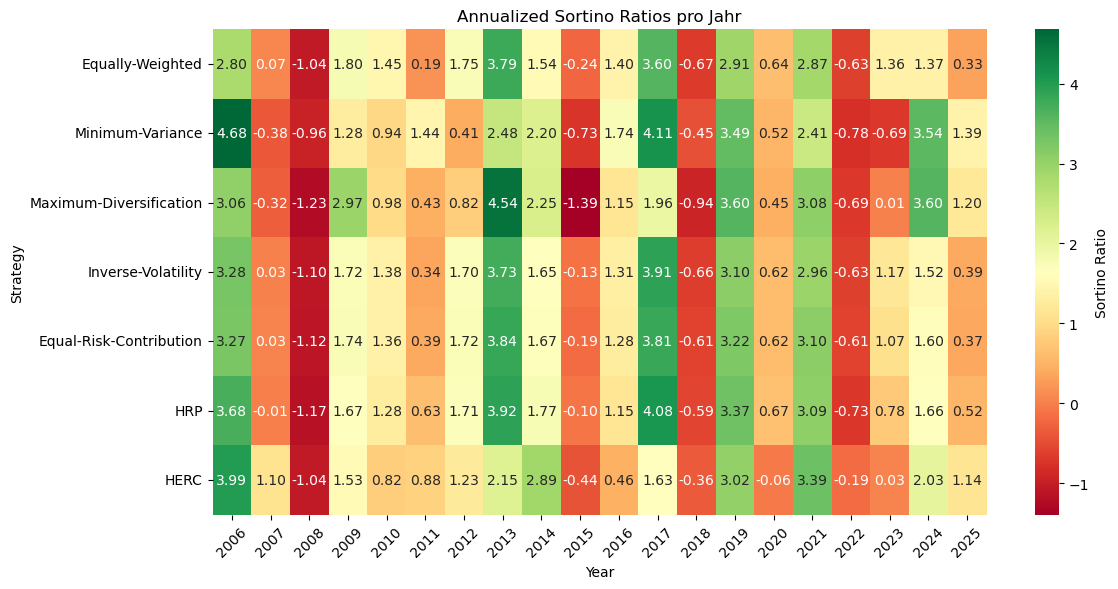

In [41]:
plt.figure(figsize=(12,6))
sb.heatmap(sortino_jahresweise.T,        
            annot=True,                  
            fmt=".2f",                   
            cmap="RdYlGn",               
            cbar_kws={'label': 'Sortino Ratio'})  

plt.title("Annualized Sortino Ratios pro Jahr")
plt.xlabel("Year")
plt.ylabel("Strategy")
plt.yticks(rotation=0)  
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

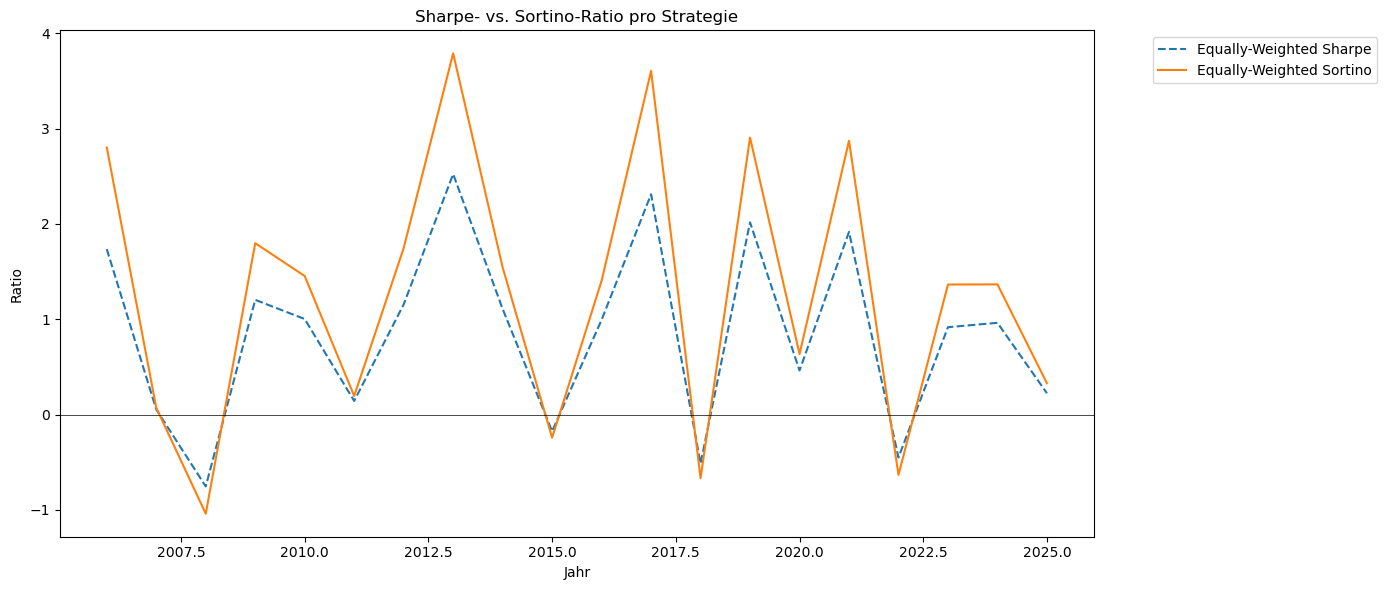

In [42]:
#Vergleich Sharpe und Sortino
strategies = sharpe_jahresweise.columns
jahre = sharpe_jahresweise.index

plt.figure(figsize=(14,6))

strategie = "Equally-Weighted"

plt.plot(jahre, sharpe_jahresweise[strategie], label=f"{strategie} Sharpe", linestyle='--')
plt.plot(jahre, sortino_jahresweise[strategie], label=f"{strategie} Sortino", linestyle='-')

plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel("Jahr")
plt.ylabel("Ratio")
plt.title("Sharpe- vs. Sortino-Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [43]:
#Funktion für annualisierten Sharpe Ratio
def sortino_annual(returns_daily):
    zins_risikofrei = 0
    mean_daily = returns_daily.mean()
    temp = (np.minimum(0, returns_daily - zins_risikofrei))**2
    temp = np.mean(temp)
    downside_dev = np.sqrt(temp)
    return (mean_daily / downside_dev) * np.sqrt(252)  # 252 Handelstage

#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
annualized_sortino = df_SP500.apply(sortino_annual)

print(annualized_sortino)

Equally-Weighted           0.716027
Minimum-Variance           0.712589
Maximum-Diversification    0.695846
Inverse-Volatility         0.720691
Equal-Risk-Contribution    0.722975
HRP                        0.738436
HERC                       0.521050
dtype: float64


In [44]:
#Funktion für annualisierten Sharpe Ratio
def sortino_total(returns_daily):
    zins_risikofrei = 0
    mean_daily = returns_daily.mean()
    temp = (np.minimum(0, returns_daily - zins_risikofrei))**2
    temp = np.mean(temp)
    downside_dev = np.sqrt(temp)
    return (mean_daily / downside_dev) * np.sqrt(4780)  # 252 Handelstage

#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
gesamt_sortino = df_SP500.apply(sortino_total)

print(gesamt_sortino)

Equally-Weighted           3.118482
Minimum-Variance           3.103509
Maximum-Diversification    3.030585
Inverse-Volatility         3.138792
Equal-Risk-Contribution    3.148742
HRP                        3.216078
HERC                       2.269304
dtype: float64


#### Maximum Drawdown

In [45]:
df_SP500.index = pd.to_datetime(df_SP500.index)
max_drawdown_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(maximum_drawdown))

In [46]:
max_drawdown_jahresweise

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.052741         -0.032493                -0.060812   
2007         -0.120954         -0.093701                -0.117456   
2008         -0.515294         -0.260699                -0.510324   
2009         -0.329569         -0.167832                -0.245241   
2010         -0.161385         -0.075105                -0.144047   
2011         -0.223591         -0.094770                -0.146034   
2012         -0.109989         -0.045625                -0.100764   
2013         -0.064595         -0.070327                -0.062808   
2014         -0.078686         -0.046328                -0.063683   
2015         -0.126782         -0.133592                -0.213227   
2016         -0.100717         -0.092176                -0.082517   
2017         -0.029483         -0.029683                -0.041328   
2018         -0.197109         -0.117381                -0.188936   
2019         -0.069984         -0.036182                -0.056132   
2020         -0.402520         -0.298542                -0.299780   
2021         -0.064116         -0.067173                -0.060611   
2022         -0.220290         -0.160825                -0.178391   
2023         -0.137794         -0.148543                -0.138079   
2024         -0.073563         -0.058303                -0.062637   
2025         -0.159367         -0.082808                -0.095453   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006           -0.045347                -0.046826 -0.039625 -0.037846  
2007           -0.113760                -0.113798 -0.099801 -0.136987  
2008           -0.472253                -0.474374 -0.426356 -0.516620  
2009           -0.292948                -0.291040 -0.260135 -0.277706  
2010           -0.140738                -0.134309 -0.116445 -0.083440  
2011           -0.192132                -0.186421 -0.155261 -0.122779  
2012           -0.086630                -0.083272 -0.063966 -0.060991  
2013           -0.064317                -0.063536 -0.063416 -0.106495  
2014           -0.072133                -0.072452 -0.067271 -0.052864  
2015           -0.114331                -0.116269 -0.107164 -0.181750  
2016           -0.089121                -0.089219 -0.080884 -0.100350  
2017           -0.026010                -0.024402 -0.021804 -0.036406  
2018           -0.185681                -0.181862 -0.173502 -0.115712  
2019           -0.059260                -0.055947 -0.047326 -0.051264  
2020           -0.389944                -0.383105 -0.364246 -0.445735  
2021           -0.057648                -0.055786 -0.058474 -0.050253  
2022           -0.208694                -0.198794 -0.200799 -0.166536  
2023           -0.129031                -0.125182 -0.121409 -0.120925  
2024           -0.073719                -0.071057 -0.067907 -0.066556  
2025           -0.141174                -0.137919 -0.124073 -0.119480

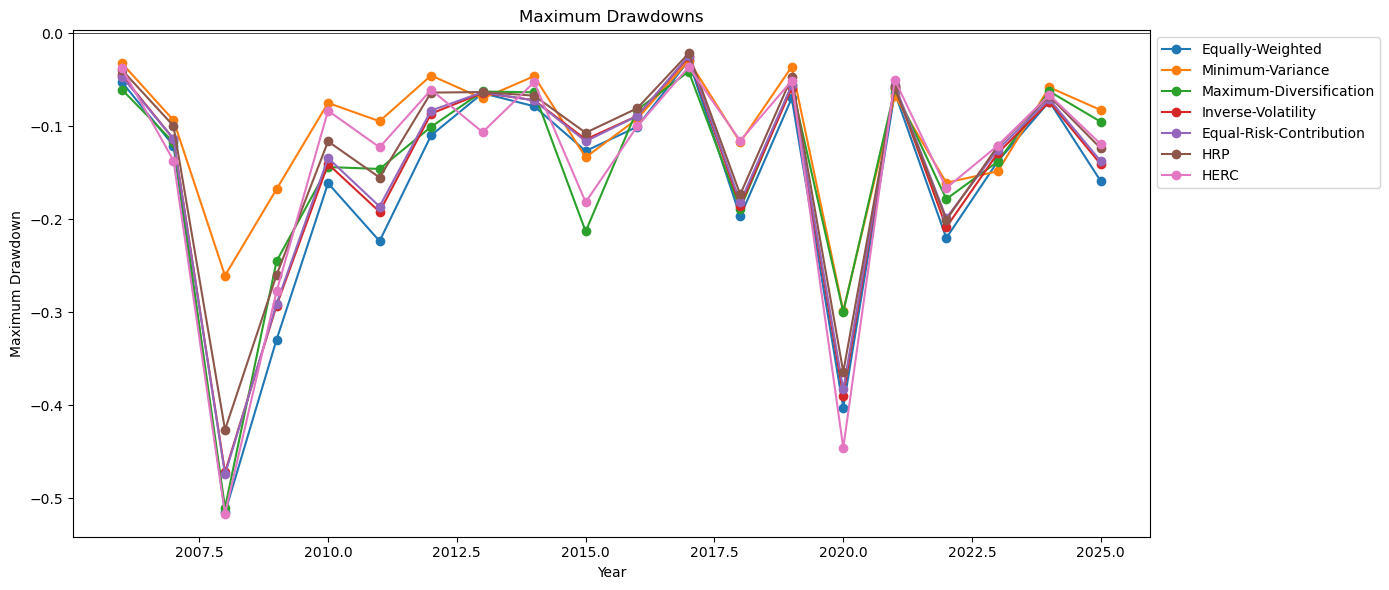

In [47]:
#Plotten der MDDs
strategien = max_drawdown_jahresweise.columns
years = max_drawdown_jahresweise.index

plt.figure(figsize=(14,6))

for strategie in strategies:
    plt.plot(years, max_drawdown_jahresweise[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  # Null-Linie
plt.xlabel("Year")
plt.ylabel("Maximum Drawdown")
plt.title("Maximum Drawdowns")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [48]:
df_SP500.index = pd.to_datetime(df_SP500.index)
max_drawdown_total = df_SP500.apply(maximum_drawdown)

max_drawdown_total.info

<bound method Series.info of Equally-Weighted          -0.587764
Minimum-Variance          -0.360774
Maximum-Diversification   -0.557210
Inverse-Volatility        -0.549557
Equal-Risk-Contribution   -0.550625
HRP                       -0.511891
HERC                      -0.547072
dtype: float64>

#### Calmar Ratio

In [49]:
df_SP500.index = pd.to_datetime(df_SP500.index)
calmar_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(calmar_ratio_total))

In [50]:
calmar_jahresweise

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          2.179965          3.941023                 1.954811   
2007         -0.041994         -0.385822                -0.370806   
2008         -0.698692         -0.734525                -0.694955   
2009          1.322154          0.814784                 2.593657   
2010          1.223029          0.899784                 0.697303   
2011          0.016052          1.335422                 0.295765   
2012          1.456276          0.437381                 0.597396   
2013          5.319122          2.333499                 6.096023   
2014          1.650061          2.865640                 3.005914   
2015         -0.304021         -0.555237                -0.780255   
2016          1.434662          1.343438                 1.243663   
2017          6.002799          5.568181                 2.544553   
2018         -0.441623         -0.375194                -0.515467   
2019          3.934712          5.933676                 4.836630   
2020          0.272121          0.222165                 0.185596   
2021          4.500694          2.502887                 4.032173   
2022         -0.552843         -0.586180                -0.564444   
2023          0.918826         -0.371158                -0.036468   
2024          1.480963          3.324924                 3.491392   
2025          0.064034          0.673861                 0.532161   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006            2.664647                 2.593593  3.097378  3.339030  
2007           -0.082175                -0.073344 -0.114022  1.031526  
2008           -0.707542                -0.708807 -0.726085 -0.758608  
2009            1.168958                 1.182525  1.058388  0.958548  
2010            1.172553                 1.172933  1.123340  0.857415  
2011            0.166449                 0.212146  0.470770  0.755401  
2012            1.580735                 1.633673  1.816801  1.151726  
2013            4.893511                 5.052672  4.836048  1.622245  
2014            1.831476                 1.846366  2.025730  3.929126  
2015           -0.216937                -0.271743 -0.194856 -0.350772  
2016            1.380139                 1.323964  1.222209  0.370258  
2017            6.760607                 6.858310  7.923802  2.024138  
2018           -0.441248                -0.415471 -0.408575 -0.354695  
2019            4.564182                 4.741835  5.471265  4.013305  
2020            0.263987                 0.269039  0.314818 -0.209749  
2021            4.734365                 4.864847  4.347669  5.634922  
2022           -0.538546                -0.525487 -0.562885 -0.254450  
2023            0.775120                 0.695645  0.475347 -0.038167  
2024            1.538589                 1.626141  1.662447  2.052227  
2025            0.102598                 0.091917  0.169493  0.467423

In [51]:
df_SP500.index = pd.to_datetime(df_SP500.index)
calmar_total = df_SP500.apply(calmar_ratio)

calmar_total.info

<bound method Series.info of Equally-Weighted           0.153641
Minimum-Variance           0.168233
Maximum-Diversification    0.135462
Inverse-Volatility         0.154601
Equal-Risk-Contribution    0.152882
HRP                        0.156752
HERC                       0.102617
dtype: float64>

In [52]:
df_SP500.index = pd.to_datetime(df_SP500.index)
calmar_total_2 = df_SP500.apply(calmar_ratio_total)

calmar_total_2.info

<bound method Series.info of Equally-Weighted           7.068941
Minimum-Variance           5.703681
Maximum-Diversification    5.340885
Inverse-Volatility         6.725922
Equal-Risk-Contribution    6.597105
HRP                        6.492310
HERC                       3.323209
dtype: float64>

#### Value at Risk

In [53]:
df_SP500.index = pd.to_datetime(df_SP500.index)
var_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(value_at_risk_func))

var_jahresweise

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.010491         -0.006440                -0.010921   
2007         -0.020285         -0.012308                -0.016892   
2008         -0.048521         -0.025777                -0.046089   
2009         -0.034961         -0.016859                -0.027531   
2010         -0.019272         -0.010333                -0.014927   
2011         -0.027043         -0.010917                -0.019460   
2012         -0.013114         -0.008264                -0.011512   
2013         -0.012371         -0.008255                -0.010069   
2014         -0.012408         -0.009024                -0.012725   
2015         -0.015875         -0.013029                -0.014999   
2016         -0.015706         -0.010660                -0.014193   
2017         -0.006278         -0.005652                -0.006986   
2018         -0.019210         -0.012684                -0.015068   
2019         -0.011918         -0.007819                -0.009380   
2020         -0.035543         -0.019354                -0.021953   
2021         -0.013948         -0.009341                -0.010768   
2022         -0.023897         -0.015067                -0.018711   
2023         -0.014564         -0.011321                -0.011329   
2024         -0.011337         -0.007768                -0.007428   
2025         -0.019416         -0.011257                -0.012831   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006           -0.009115                -0.009144 -0.007877 -0.008213  
2007           -0.019878                -0.019556 -0.017755 -0.021686  
2008           -0.043191                -0.042194 -0.039032 -0.052236  
2009           -0.028632                -0.028615 -0.024840 -0.025752  
2010           -0.017504                -0.016959 -0.014700 -0.014037  
2011           -0.023821                -0.023342 -0.019544 -0.015257  
2012           -0.011394                -0.011303 -0.010320 -0.008978  
2013           -0.011145                -0.011223 -0.010387 -0.011883  
2014           -0.011614                -0.011654 -0.010973 -0.010010  
2015           -0.015735                -0.015528 -0.015265 -0.015223  
2016           -0.014562                -0.014235 -0.013970 -0.014628  
2017           -0.005654                -0.005609 -0.005242 -0.007226  
2018           -0.018643                -0.018299 -0.017471 -0.012888  
2019           -0.010500                -0.010162 -0.009496 -0.009297  
2020           -0.031855                -0.030977 -0.028907 -0.032535  
2021           -0.012438                -0.011899 -0.011709 -0.011820  
2022           -0.022061                -0.021548 -0.019824 -0.020759  
2023           -0.013831                -0.013282 -0.012102 -0.013481  
2024           -0.009866                -0.009617 -0.009707 -0.008790  
2025           -0.018105                -0.018250 -0.016611 -0.017637

In [54]:
df_SP500.index = pd.to_datetime(df_SP500.index)
var_total = df_SP500.apply(value_at_risk_func)

var_total.info

<bound method Series.info of Equally-Weighted          -0.019831
Minimum-Variance          -0.012058
Maximum-Diversification   -0.015863
Inverse-Volatility        -0.018002
Equal-Risk-Contribution   -0.017691
HRP                       -0.015956
HERC                      -0.016015
dtype: float64>

In [55]:
monthly_returns = df_SP500.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_var = monthly_returns.apply(value_at_risk_func)

monthly_var.info

<bound method Series.info of Equally-Weighted          -0.080313
Minimum-Variance          -0.048661
Maximum-Diversification   -0.061475
Inverse-Volatility        -0.071116
Equal-Risk-Contribution   -0.068352
HRP                       -0.062364
HERC                      -0.059319
dtype: float64>

#### Expected Shortfall

In [56]:
df_SP500.index = pd.to_datetime(df_SP500.index)
es_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(expected_shortfall))

es_jahresweise

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.013415         -0.008909                -0.013029   
2007         -0.026444         -0.017031                -0.021159   
2008         -0.069694         -0.040060                -0.064042   
2009         -0.049179         -0.022276                -0.036245   
2010         -0.029278         -0.015865                -0.022688   
2011         -0.038664         -0.017771                -0.027709   
2012         -0.018481         -0.011039                -0.014854   
2013         -0.016722         -0.013190                -0.014888   
2014         -0.017630         -0.011806                -0.016860   
2015         -0.022323         -0.018327                -0.023774   
2016         -0.022358         -0.013768                -0.017538   
2017         -0.009577         -0.007861                -0.010653   
2018         -0.025535         -0.018498                -0.020699   
2019         -0.019310         -0.012034                -0.014380   
2020         -0.062041         -0.044635                -0.048505   
2021         -0.019205         -0.013864                -0.015573   
2022         -0.031764         -0.021422                -0.024643   
2023         -0.017625         -0.014396                -0.014753   
2024         -0.016378         -0.010140                -0.011275   
2025         -0.033197         -0.018820                -0.021937   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006           -0.011883                -0.012126 -0.010782 -0.010294  
2007           -0.025383                -0.025049 -0.022874 -0.027858  
2008           -0.062611                -0.062264 -0.055470 -0.077435  
2009           -0.041076                -0.040805 -0.034220 -0.039080  
2010           -0.026139                -0.025239 -0.022402 -0.020309  
2011           -0.035166                -0.034476 -0.029978 -0.023363  
2012           -0.016359                -0.016004 -0.013668 -0.010619  
2013           -0.015692                -0.015548 -0.014732 -0.015790  
2014           -0.016708                -0.016655 -0.015915 -0.013511  
2015           -0.021404                -0.021483 -0.020664 -0.024328  
2016           -0.020443                -0.020210 -0.018816 -0.020505  
2017           -0.008885                -0.008718 -0.008334 -0.008867  
2018           -0.024715                -0.024209 -0.023476 -0.020072  
2019           -0.017854                -0.016758 -0.015642 -0.013571  
2020           -0.059895                -0.058647 -0.055614 -0.066868  
2021           -0.018108                -0.017182 -0.016247 -0.016189  
2022           -0.029449                -0.028357 -0.026623 -0.025870  
2023           -0.016684                -0.016042 -0.015227 -0.016933  
2024           -0.014871                -0.014348 -0.013074 -0.012582  
2025           -0.030487                -0.029874 -0.026771 -0.026432

In [57]:
df_SP500.index = pd.to_datetime(df_SP500.index)
es_total = df_SP500.apply(expected_shortfall)

es_total.info

<bound method Series.info of Equally-Weighted          -0.033337
Minimum-Variance          -0.019684
Maximum-Diversification   -0.026754
Inverse-Volatility        -0.030247
Equal-Risk-Contribution   -0.029689
HRP                       -0.026865
HERC                      -0.029903
dtype: float64>

In [58]:
monthly_returns = df_SP500.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_es  = monthly_returns.apply(expected_shortfall)

monthly_es.info

<bound method Series.info of Equally-Weighted          -0.112427
Minimum-Variance          -0.068221
Maximum-Diversification   -0.097727
Inverse-Volatility        -0.102518
Equal-Risk-Contribution   -0.101233
HRP                       -0.092760
HERC                      -0.103312
dtype: float64>

In [59]:
yearly_returns = df_SP500.resample('Y').apply(lambda x: (1 + x).prod() - 1)
yearly_es  = yearly_returns.apply(expected_shortfall)

yearly_es.info

<bound method Series.info of Equally-Weighted          -0.360032
Minimum-Variance          -0.191490
Maximum-Diversification   -0.354652
Inverse-Volatility        -0.334139
Equal-Risk-Contribution   -0.336239
HRP                       -0.309571
HERC                      -0.391912
dtype: float64>

In [60]:
#Zusammenfassung der Metriken
Zusammenfassung = pd.concat([total_sharpe, annualized_sharpe, annualized_sortino, max_drawdown_total, calmar_total_2, monthly_var, monthly_es], axis=1)
Zusammenfassung.columns = ["Sharpe", "Sharp_Ann", "Sortino", "Max Drawdown", "Calmar", "Var", "ES"]
print(Zusammenfassung)

                           Sharpe  Sharp_Ann   Sortino  Max Drawdown  \
Equally-Weighted         2.211253   0.507720  0.716027     -0.587764   
Minimum-Variance         2.208165   0.507011  0.712589     -0.360774   
Maximum-Diversification  2.177408   0.499950  0.695846     -0.557210   
Inverse-Volatility       2.234629   0.513088  0.720691     -0.549557   
Equal-Risk-Contribution  2.245792   0.515651  0.722975     -0.550625   
HRP                      2.299379   0.527955  0.738436     -0.511891   
HERC                     1.632558   0.374848  0.521050     -0.547072   

                           Calmar       Var        ES  
Equally-Weighted         7.068941 -0.080313 -0.112427  
Minimum-Variance         5.703681 -0.048661 -0.068221  
Maximum-Diversification  5.340885 -0.061475 -0.097727  
Inverse-Volatility       6.725922 -0.071116 -0.102518  
Equal-Risk-Contribution  6.597105 -0.068352 -0.101233  
HRP                      6.492310 -0.062364 -0.092760  
HERC                     3.3232

## S&P 500 mit Ledoit-Shrinkage

In [61]:
#Bearbeitete SP500-Daten (Gesamtbestand)

df_SP500_shrinked = pd.read_csv(
    'returnssp500shrinked_neu_f.csv',
    sep=',',
    encoding='utf-8',
    index_col=0,
    decimal = '.',
    low_memory=False,
    parse_dates=['Date'],
    dayfirst=True
)

In [62]:
df_SP500_shrinked.info

<bound method DataFrame.info of             Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0     2006-06-01          0.012900          0.010584                 0.010986   
1     2006-06-02          0.001590          0.000545                 0.001427   
2     2006-06-05         -0.019401         -0.011641                -0.015187   
3     2006-06-06         -0.002777          0.002887                -0.002299   
4     2006-06-07         -0.005689         -0.000096                -0.000634   
...          ...               ...               ...                      ...   
4775  2025-05-23         -0.003974          0.001147                -0.000438   
4776  2025-05-27          0.018501          0.009232                 0.008390   
4777  2025-05-28         -0.008744         -0.006262                -0.006523   
4778  2025-05-29          0.003698          0.003004                 0.002230   
4779  2025-05-30         -0.000446          0.004944                 0.006350

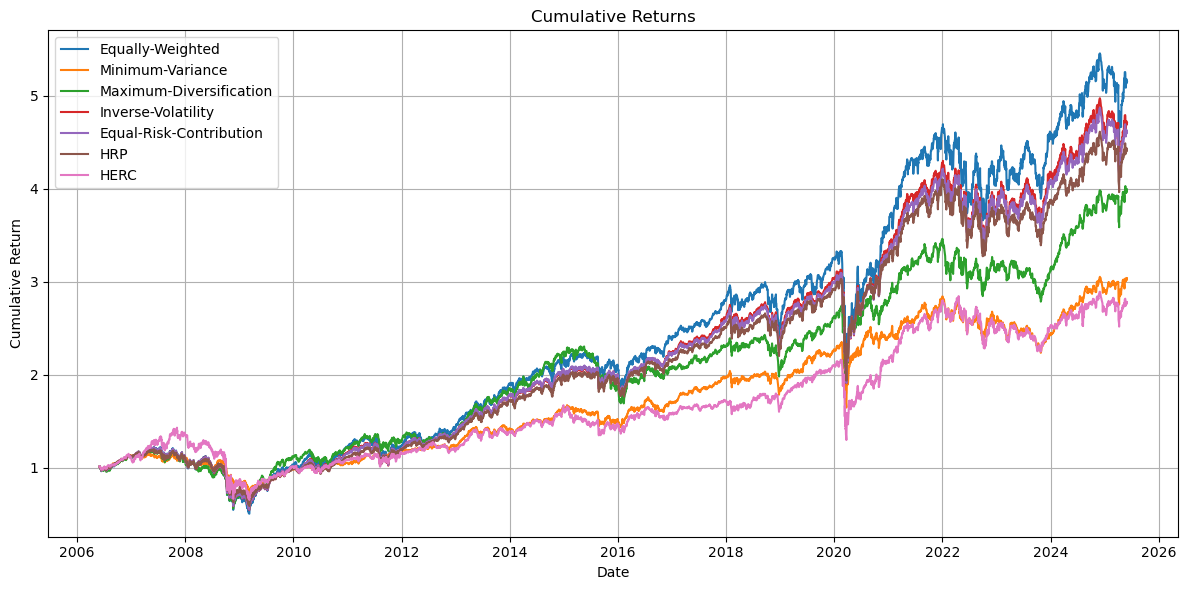

In [63]:
df_SP500_shrinked["Date"] = pd.to_datetime(df_SP500_shrinked["Date"])

#Date-Spalte als Index setzen
df_SP500_shrinked = df_SP500_shrinked.set_index("Date")

#Kumulierte Rendite berechnen (angenommen tägliche Returns)
#(1 + r).cumprod() - 1 ergibt den Gesamtzuwachs in Prozent
kumulative_returns = gesamt_return(df_SP500_shrinked)

#Plot
plt.figure(figsize=(12,6))
plt.plot(kumulative_returns)
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(kumulative_returns.columns, loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [64]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
sharpe_jahresweise_shrinked = df_SP500_shrinked.groupby(df_SP500_shrinked.index.year).apply(lambda x: x.apply(lambda y: sharpe_ratio(y) * np.sqrt(252)))

In [65]:
sharpe_jahresweise_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          1.735345          2.895575                 2.021266   
2007          0.053772         -0.217701                -0.239844   
2008         -0.754120         -0.780789                -0.905762   
2009          1.203315          0.918293                 1.901638   
2010          1.002074          0.702408                 0.724553   
2011          0.142605          1.037154                 0.363247   
2012          1.155302          0.363046                 0.577070   
2013          2.522322          1.774018                 2.889895   
2014          1.108489          1.591353                 1.575939   
2015         -0.175824         -0.576275                -1.038829   
2016          0.993231          1.235115                 0.851641   
2017          2.310931          2.697695                 1.523513   
2018         -0.513253         -0.446958                -0.720729   
2019          2.016029          2.429412                 2.470473   
2020          0.462482          0.351864                 0.356057   
2021          1.915870          1.692825                 2.044367   
2022         -0.450430         -0.583095                -0.486757   
2023          0.916477         -0.516415                 0.010098   
2024          0.962259          2.319202                 2.341271   
2025          0.223548          0.868031                 0.860725   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006            1.973929                 1.971924  2.214682  1.861653  
2007            0.024939                 0.027342 -0.026328  1.120466  
2008           -0.792803                -0.812637 -0.844871 -0.663445  
2009            1.162735                 1.175757  1.163935  0.790570  
2010            0.953615                 0.940578  0.894695  0.620658  
2011            0.244596                 0.284451  0.456174  0.507199  
2012            1.132799                 1.142773  1.088176  0.259693  
2013            2.473131                 2.540810  2.583750  1.472107  
2014            1.170412                 1.192318  1.279911  1.532845  
2015           -0.096142                -0.126789 -0.056347 -0.580245  
2016            0.930417                 0.904550  0.865834  0.703447  
2017            2.478225                 2.423352  2.573694  1.332993  
2018           -0.504437                -0.489528 -0.471107 -0.163697  
2019            2.131077                 2.218426  2.320658  2.594738  
2020            0.452363                 0.454970  0.486967  0.256952  
2021            1.976364                 2.062640  2.097679  2.191484  
2022           -0.453199                -0.434474 -0.505909 -0.561599  
2023            0.802976                 0.725246  0.578642  0.150204  
2024            1.052325                 1.114147  1.187073  0.687974  
2025            0.260564                 0.253628  0.388661  0.505008

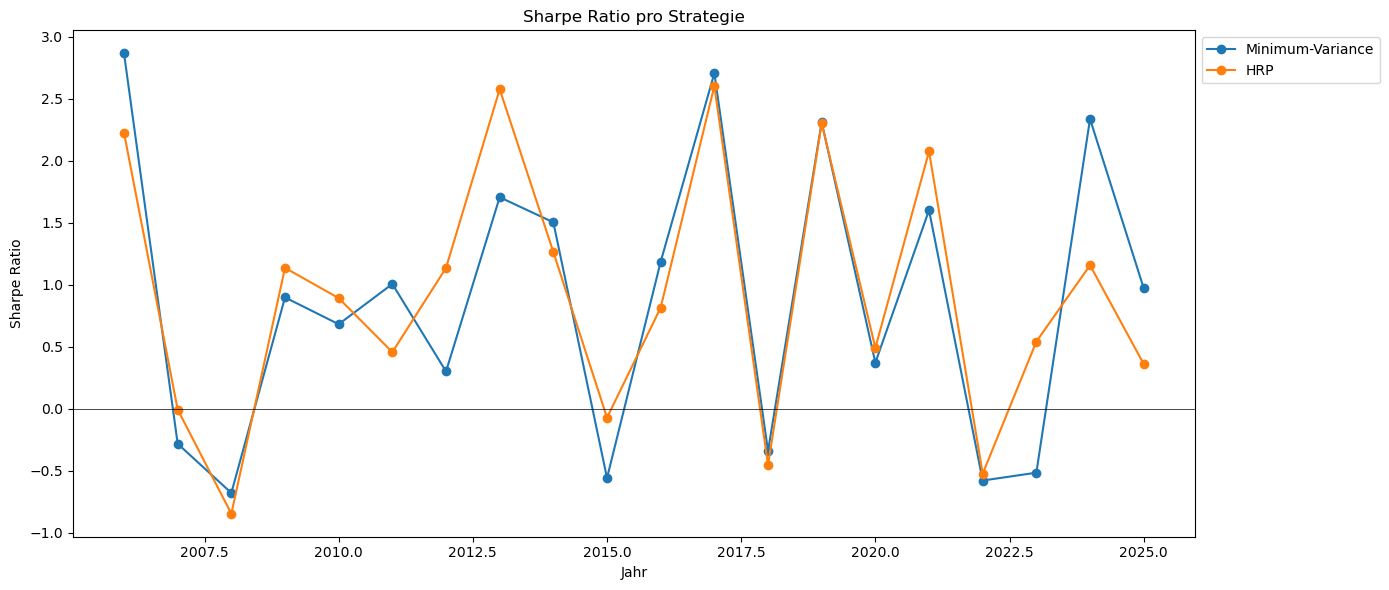

In [66]:
#Plotten der SR
strategien = sharpe_jahresweise.columns
years = sharpe_jahresweise.index

plt.figure(figsize=(14,6))

strategie = "Minimum-Variance"
plt.plot(years, sharpe_jahresweise[strategie], label=strategie, marker='o')

strategie = "HRP"
plt.plot(years, sharpe_jahresweise[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  
plt.xlabel("Jahr")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [67]:
#Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
annual_sharpe_shrinked = df_SP500_shrinked.apply(sharpe_annual)

print(annual_sharpe_shrinked)

Equally-Weighted           0.507720
Minimum-Variance           0.505345
Maximum-Diversification    0.512605
Inverse-Volatility         0.511829
Equal-Risk-Contribution    0.514732
HRP                        0.535768
HERC                       0.374016
dtype: float64


In [68]:
#Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
gesamt_sharpe_shrinked = df_SP500_shrinked.apply(sharpe_total)

print(gesamt_sharpe_shrinked)

Equally-Weighted           2.211253
Minimum-Variance           2.200908
Maximum-Diversification    2.232527
Inverse-Volatility         2.229145
Equal-Risk-Contribution    2.241792
HRP                        2.333406
HERC                       1.628935
dtype: float64


#### Sortino Ratio

In [69]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
sortino_jahresweise_shrinked = df_SP500_shrinked.groupby(df_SP500_shrinked.index.year).apply(lambda x: x.apply(lambda y: sortino_ratio(y) * np.sqrt(252)))

sortino_jahresweise_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          2.801290          4.768826                 3.155998   
2007          0.071483         -0.290633                -0.318256   
2008         -1.040119         -1.099443                -1.221259   
2009          1.797767          1.312492                 2.847136   
2010          1.453103          0.974962                 0.999372   
2011          0.194655          1.484416                 0.499114   
2012          1.746507          0.504900                 0.832400   
2013          3.789072          2.588818                 4.453590   
2014          1.543562          2.335901                 2.329848   
2015         -0.243038         -0.759746                -1.368053   
2016          1.403578          1.820647                 1.256666   
2017          3.604969          4.113162                 2.214755   
2018         -0.667402         -0.580060                -0.936826   
2019          2.905662          3.693252                 3.614755   
2020          0.635325          0.489197                 0.479626   
2021          2.872272          2.521660                 3.062150   
2022         -0.632442         -0.785373                -0.662149   
2023          1.363923         -0.696323                 0.013971   
2024          1.365625          3.509145                 3.655698   
2025          0.328134          1.242860                 1.252427   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006            3.241070                 3.233422  3.670684  2.934308  
2007            0.033075                 0.036157 -0.034805  1.526159  
2008           -1.095492                -1.121458 -1.170206 -0.926748  
2009            1.720568                 1.738348  1.709592  1.124594  
2010            1.380093                 1.357844  1.283777  0.880597  
2011            0.334439                 0.389043  0.625715  0.703732  
2012            1.705909                 1.719235  1.632012  0.376800  
2013            3.739675                 3.839793  3.941438  2.196849  
2014            1.637120                 1.669125  1.796260  2.266948  
2015           -0.133114                -0.175219 -0.077889 -0.766114  
2016            1.313423                 1.279388  1.225731  0.971452  
2017            3.894592                 3.790814  4.033214  1.986152  
2018           -0.653103                -0.633594 -0.608304 -0.217396  
2019            3.082093                 3.223227  3.412793  4.010890  
2020            0.618526                 0.619542  0.663941  0.345511  
2021            2.950672                 3.085814  3.123793  3.248979  
2022           -0.635790                -0.607914 -0.701739 -0.758053  
2023            1.181728                 1.062098  0.838130  0.215023  
2024            1.503217                 1.596644  1.710176  0.973849  
2025            0.378932                 0.367803  0.561268  0.722248

In [70]:
#Annualisierte Sortino
annualized_sortino_shrinked = df_SP500_shrinked.apply(sortino_annual)
print(annualized_sortino_shrinked)

Equally-Weighted           0.716027
Minimum-Variance           0.708964
Maximum-Diversification    0.712760
Inverse-Volatility         0.719012
Equal-Risk-Contribution    0.721811
HRP                        0.750376
HERC                       0.520111
dtype: float64


In [71]:
#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
gesamt_sortino_shrinked = df_SP500_shrinked.apply(sortino_total)

print(gesamt_sortino_shrinked)

Equally-Weighted           3.118482
Minimum-Variance           3.087721
Maximum-Diversification    3.104254
Inverse-Volatility         3.131480
Equal-Risk-Contribution    3.143670
HRP                        3.268081
HERC                       2.265215
dtype: float64


In [72]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
max_drawdown_jahresweise_shrinked = df_SP500_shrinked.groupby(df_SP500_shrinked.index.year).apply(lambda x: x.apply(maximum_drawdown))

max_drawdown_jahresweise_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.052741         -0.032279                -0.055842   
2007         -0.120954         -0.087380                -0.113551   
2008         -0.515294         -0.281163                -0.482201   
2009         -0.329569         -0.163790                -0.233888   
2010         -0.161385         -0.076248                -0.136684   
2011         -0.223591         -0.093211                -0.139299   
2012         -0.109989         -0.045447                -0.090763   
2013         -0.064595         -0.070426                -0.062978   
2014         -0.078686         -0.045141                -0.060802   
2015         -0.126782         -0.134585                -0.208409   
2016         -0.100717         -0.091963                -0.077627   
2017         -0.029483         -0.029288                -0.038340   
2018         -0.197109         -0.125414                -0.184527   
2019         -0.069984         -0.034831                -0.051660   
2020         -0.402520         -0.299778                -0.302100   
2021         -0.064116         -0.066231                -0.059661   
2022         -0.220290         -0.166525                -0.176440   
2023         -0.137794         -0.149909                -0.136634   
2024         -0.073563         -0.056281                -0.058968   
2025         -0.159367         -0.084898                -0.090297   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006           -0.046101                -0.048022 -0.039253 -0.038872  
2007           -0.114568                -0.113679 -0.101436 -0.114414  
2008           -0.476518                -0.474398 -0.425946 -0.508485  
2009           -0.295114                -0.291041 -0.258520 -0.253968  
2010           -0.142113                -0.134520 -0.114948 -0.080827  
2011           -0.194418                -0.186441 -0.155182 -0.122538  
2012           -0.087597                -0.083411 -0.063511 -0.094405  
2013           -0.064217                -0.063540 -0.063794 -0.085981  
2014           -0.072683                -0.072450 -0.065341 -0.053019  
2015           -0.114886                -0.116287 -0.105610 -0.186505  
2016           -0.089747                -0.089223 -0.077286 -0.085468  
2017           -0.026347                -0.024401 -0.022512 -0.040874  
2018           -0.186843                -0.184507 -0.172893 -0.109660  
2019           -0.060163                -0.055970 -0.045732 -0.029008  
2020           -0.390664                -0.382912 -0.361054 -0.399607  
2021           -0.058371                -0.055799 -0.058486 -0.067317  
2022           -0.209518                -0.199261 -0.200883 -0.198029  
2023           -0.129480                -0.125459 -0.120436 -0.120523  
2024           -0.073858                -0.071814 -0.068031 -0.085305  
2025           -0.143626                -0.137901 -0.123195 -0.109715

In [73]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
max_drawdown_total_shrinked = df_SP500_shrinked.apply(maximum_drawdown)

max_drawdown_total_shrinked.info

<bound method Series.info of Equally-Weighted          -0.587764
Minimum-Variance          -0.371292
Maximum-Diversification   -0.534103
Inverse-Volatility        -0.552715
Equal-Risk-Contribution   -0.550552
HRP                       -0.509888
HERC                      -0.543501
dtype: float64>

#### Calmar Ratio

In [74]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
calmar_jahresweise_shrinked = df_SP500_shrinked.groupby(df_SP500_shrinked.index.year).apply(lambda x: x.apply(calmar_ratio_total))

calmar_jahresweise_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          2.179965          3.978178                 2.105977   
2007         -0.041994         -0.338460                -0.377400   
2008         -0.698692         -0.756228                -0.694730   
2009          1.322154          0.839676                 2.380006   
2010          1.223029          0.921802                 0.730734   
2011          0.016052          1.411201                 0.368886   
2012          1.456276          0.536193                 0.645663   
2013          5.319122          2.409895                 5.842894   
2014          1.650061          3.134925                 3.195872   
2015         -0.304021         -0.569028                -0.774224   
2016          1.434662          1.390646                 1.433559   
2017          6.002799          5.497282                 2.961787   
2018         -0.441623         -0.442683                -0.526016   
2019          3.934712          6.491927                 5.196820   
2020          0.272121          0.202493                 0.208556   
2021          4.500694          2.685985                 3.979316   
2022         -0.552843         -0.569194                -0.547037   
2023          0.918826         -0.363959                -0.035020   
2024          1.480963          3.386839                 3.716390   
2025          0.064034          0.584043                 0.584018   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006            2.615966                 2.524364  3.104333  2.794486  
2007           -0.077761                -0.071886 -0.141703  1.971740  
2008           -0.706826                -0.708755 -0.724220 -0.728464  
2009            1.173445                 1.183035  1.097784  0.676872  
2010            1.174594                 1.171453  1.142007  0.958016  
2011            0.155236                 0.211728  0.471072  0.619478  
2012            1.577643                 1.629110  1.736307  0.203635  
2013            4.935406                 5.048930  4.827961  2.012480  
2014            1.814484                 1.848749  2.114054  3.072413  
2015           -0.221991                -0.256953 -0.176320 -0.532552  
2016            1.379672                 1.324774  1.360052  0.994158  
2017            6.715902                 6.829314  7.596069  2.109311  
2018           -0.439382                -0.425926 -0.420013 -0.268782  
2019            4.496928                 4.751900  5.707161  9.030053  
2020            0.265538                 0.270992  0.313550  0.067933  
2021            4.691978                 4.843639  4.426877  4.389739  
2022           -0.539796                -0.526053 -0.547687 -0.567107  
2023            0.782881                 0.691254  0.516589  0.088114  
2024            1.531847                 1.610492  1.720464  0.909940  
2025            0.094130                 0.092656  0.189494  0.273041

In [75]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
calmar_total_2_shrinked = df_SP500_shrinked.apply(calmar_ratio_total)

calmar_total_2_shrinked.info

<bound method Series.info of Equally-Weighted           7.068941
Minimum-Variance           5.494166
Maximum-Diversification    5.609414
Inverse-Volatility         6.713581
Equal-Risk-Contribution    6.577890
HRP                        6.727255
HERC                       3.280721
dtype: float64>

##### Value at Risk

In [76]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
var_jahresweise_shrinked = df_SP500_shrinked.groupby(df_SP500_shrinked.index.year).apply(lambda x: x.apply(value_at_risk_func))

var_jahresweise_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.010491         -0.006186                -0.010383   
2007         -0.020285         -0.012888                -0.016492   
2008         -0.048521         -0.026720                -0.044233   
2009         -0.034961         -0.016823                -0.025914   
2010         -0.019272         -0.010403                -0.014819   
2011         -0.027043         -0.010986                -0.018070   
2012         -0.013114         -0.008454                -0.010868   
2013         -0.012371         -0.008434                -0.010007   
2014         -0.012408         -0.009282                -0.012316   
2015         -0.015875         -0.013011                -0.014967   
2016         -0.015706         -0.010562                -0.013859   
2017         -0.006278         -0.005369                -0.006780   
2018         -0.019210         -0.012810                -0.015336   
2019         -0.011918         -0.007741                -0.008906   
2020         -0.035543         -0.020059                -0.021863   
2021         -0.013948         -0.009444                -0.010628   
2022         -0.023897         -0.015155                -0.018634   
2023         -0.014564         -0.010997                -0.011328   
2024         -0.011337         -0.007650                -0.007692   
2025         -0.019416         -0.011649                -0.012227   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006           -0.009176                -0.009221 -0.007761 -0.008747  
2007           -0.019966                -0.019627 -0.017824 -0.022870  
2008           -0.043816                -0.042243 -0.038505 -0.054148  
2009           -0.028909                -0.028619 -0.024935 -0.025156  
2010           -0.017643                -0.016962 -0.014585 -0.014037  
2011           -0.024086                -0.023345 -0.019726 -0.016798  
2012           -0.011465                -0.011297 -0.010262 -0.008955  
2013           -0.011243                -0.011222 -0.010273 -0.010262  
2014           -0.011676                -0.011655 -0.010934 -0.010272  
2015           -0.015773                -0.015649 -0.015149 -0.016193  
2016           -0.014591                -0.014235 -0.013786 -0.014779  
2017           -0.005684                -0.005610 -0.005253 -0.006619  
2018           -0.018789                -0.018298 -0.017390 -0.013728  
2019           -0.010597                -0.010162 -0.009574 -0.008059  
2020           -0.032117                -0.031147 -0.028666 -0.030045  
2021           -0.012593                -0.011880 -0.011764 -0.011405  
2022           -0.022157                -0.021549 -0.019795 -0.019733  
2023           -0.013871                -0.013343 -0.012104 -0.012422  
2024           -0.010008                -0.009601 -0.009708 -0.010518  
2025           -0.018341                -0.018251 -0.016523 -0.014600

In [77]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
var_total_shrinked = df_SP500_shrinked.apply(value_at_risk_func)

var_total_shrinked.info

<bound method Series.info of Equally-Weighted          -0.019831
Minimum-Variance          -0.012263
Maximum-Diversification   -0.015412
Inverse-Volatility        -0.018096
Equal-Risk-Contribution   -0.017695
HRP                       -0.016010
HERC                      -0.016240
dtype: float64>

In [78]:
monthly_returns_shrinked = df_SP500_shrinked.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_var_shrinked = monthly_returns_shrinked.apply(value_at_risk_func)

monthly_var_shrinked.info

<bound method Series.info of Equally-Weighted          -0.080313
Minimum-Variance          -0.049808
Maximum-Diversification   -0.061998
Inverse-Volatility        -0.072043
Equal-Risk-Contribution   -0.068365
HRP                       -0.061636
HERC                      -0.062401
dtype: float64>

#### Expected Shortfall

In [79]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
es_jahresweise_shrinked = df_SP500_shrinked.groupby(df_SP500_shrinked.index.year).apply(lambda x: x.apply(expected_shortfall))

es_jahresweise_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.013415         -0.008708                -0.012432   
2007         -0.026444         -0.016902                -0.020836   
2008         -0.069694         -0.040226                -0.060524   
2009         -0.049179         -0.021566                -0.033736   
2010         -0.029278         -0.015836                -0.022097   
2011         -0.038664         -0.017876                -0.026583   
2012         -0.018481         -0.010705                -0.014215   
2013         -0.016722         -0.013018                -0.014558   
2014         -0.017630         -0.011853                -0.016515   
2015         -0.022323         -0.018442                -0.023563   
2016         -0.022358         -0.013476                -0.017201   
2017         -0.009577         -0.007724                -0.010069   
2018         -0.025535         -0.018608                -0.020740   
2019         -0.019310         -0.011957                -0.014220   
2020         -0.062041         -0.044952                -0.048198   
2021         -0.019205         -0.013982                -0.015117   
2022         -0.031764         -0.021258                -0.024485   
2023         -0.017625         -0.014179                -0.014706   
2024         -0.016378         -0.010149                -0.011165   
2025         -0.033197         -0.019188                -0.021500   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006           -0.012015                -0.012265 -0.010736 -0.012662  
2007           -0.025491                -0.025064 -0.023042 -0.029939  
2008           -0.063215                -0.062292 -0.055289 -0.079281  
2009           -0.041525                -0.040811 -0.034139 -0.035343  
2010           -0.026334                -0.025268 -0.022376 -0.020377  
2011           -0.035413                -0.034488 -0.029998 -0.025372  
2012           -0.016463                -0.016012 -0.013600 -0.011196  
2013           -0.015767                -0.015548 -0.014729 -0.014915  
2014           -0.016782                -0.016655 -0.015892 -0.013768  
2015           -0.021448                -0.021511 -0.020722 -0.024522  
2016           -0.020538                -0.020200 -0.018596 -0.018729  
2017           -0.008965                -0.008718 -0.008415 -0.008664  
2018           -0.024826                -0.024375 -0.023291 -0.020685  
2019           -0.017962                -0.016776 -0.015523 -0.012946  
2020           -0.060052                -0.058621 -0.055206 -0.060369  
2021           -0.018210                -0.017211 -0.016352 -0.017620  
2022           -0.029564                -0.028365 -0.026601 -0.025216  
2023           -0.016728                -0.016043 -0.015193 -0.015258  
2024           -0.015004                -0.014379 -0.013102 -0.017259  
2025           -0.030855                -0.029876 -0.026765 -0.021744

In [80]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
es_total_shrinked = df_SP500_shrinked.apply(expected_shortfall)

es_total_shrinked.info

<bound method Series.info of Equally-Weighted          -0.033337
Minimum-Variance          -0.019697
Maximum-Diversification   -0.025837
Inverse-Volatility        -0.030458
Equal-Risk-Contribution   -0.029716
HRP                       -0.026804
HERC                      -0.029409
dtype: float64>

In [81]:
monthly_returns_shrinked = df_SP500_shrinked.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_es_shrinked  = monthly_returns_shrinked.apply(expected_shortfall)

monthly_es_shrinked.info

<bound method Series.info of Equally-Weighted          -0.112427
Minimum-Variance          -0.069544
Maximum-Diversification   -0.093863
Inverse-Volatility        -0.103245
Equal-Risk-Contribution   -0.101129
HRP                       -0.092372
HERC                      -0.096744
dtype: float64>

In [82]:
yearly_returns_shrinked = df_SP500_shrinked.resample('Y').apply(lambda x: (1 + x).prod() - 1)
yearly_es_shrinked  = yearly_returns_shrinked.apply(expected_shortfall)

yearly_es_shrinked.info

<bound method Series.info of Equally-Weighted          -0.360032
Minimum-Variance          -0.212623
Maximum-Diversification   -0.334999
Inverse-Volatility        -0.336815
Equal-Risk-Contribution   -0.336232
HRP                       -0.308479
HERC                      -0.370413
dtype: float64>

In [83]:
#Zusammenfassung der Metriken
Zusammenfassung_shrinked = pd.concat([gesamt_sharpe_shrinked, annual_sharpe_shrinked, annualized_sortino_shrinked, max_drawdown_total_shrinked, calmar_total_2_shrinked, monthly_var_shrinked, monthly_es_shrinked], axis=1)
Zusammenfassung_shrinked.columns = ["Sharpe","Sharpe_Ann","Sortino", "Max Drawdown", "Calmar", "Var", "ES"]
print(Zusammenfassung_shrinked)

                           Sharpe  Sharpe_Ann   Sortino  Max Drawdown  \
Equally-Weighted         2.211253    0.507720  0.716027     -0.587764   
Minimum-Variance         2.200908    0.505345  0.708964     -0.371292   
Maximum-Diversification  2.232527    0.512605  0.712760     -0.534103   
Inverse-Volatility       2.229145    0.511829  0.719012     -0.552715   
Equal-Risk-Contribution  2.241792    0.514732  0.721811     -0.550552   
HRP                      2.333406    0.535768  0.750376     -0.509888   
HERC                     1.628935    0.374016  0.520111     -0.543501   

                           Calmar       Var        ES  
Equally-Weighted         7.068941 -0.080313 -0.112427  
Minimum-Variance         5.494166 -0.049808 -0.069544  
Maximum-Diversification  5.609414 -0.061998 -0.093863  
Inverse-Volatility       6.713581 -0.072043 -0.103245  
Equal-Risk-Contribution  6.577890 -0.068365 -0.101129  
HRP                      6.727255 -0.061636 -0.092372  
HERC                   

## 2-Jahre Trainingsfenster S&P500

In [84]:
#Bearbeitete SP500-Daten (Gesamtbestand, 2 Jahre)

df_SP500_2jahre = pd.read_csv(
    'renditensp500_neu_2jahre_f.csv',
    sep=',',
    encoding='utf-8',
    index_col=0,
    decimal = '.',
    low_memory=False,
    parse_dates=['Date'],
    dayfirst=True
)

In [85]:
df_SP500_2jahre.info

<bound method DataFrame.info of             Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0     2007-06-01          0.004099          0.005620                 0.008061   
1     2007-06-04          0.001869         -0.001130                 0.000377   
2     2007-06-05         -0.006664         -0.008668                -0.007603   
3     2007-06-06         -0.009787         -0.006737                -0.007762   
4     2007-06-07         -0.019440         -0.013501                -0.013076   
...          ...               ...               ...                      ...   
4524  2025-05-23         -0.003445          0.001861                 0.001533   
4525  2025-05-27          0.018291          0.010889                 0.009485   
4526  2025-05-28         -0.008780         -0.004721                -0.006528   
4527  2025-05-29          0.003932          0.002558                 0.001647   
4528  2025-05-30         -0.000518          0.006194                 0.006684

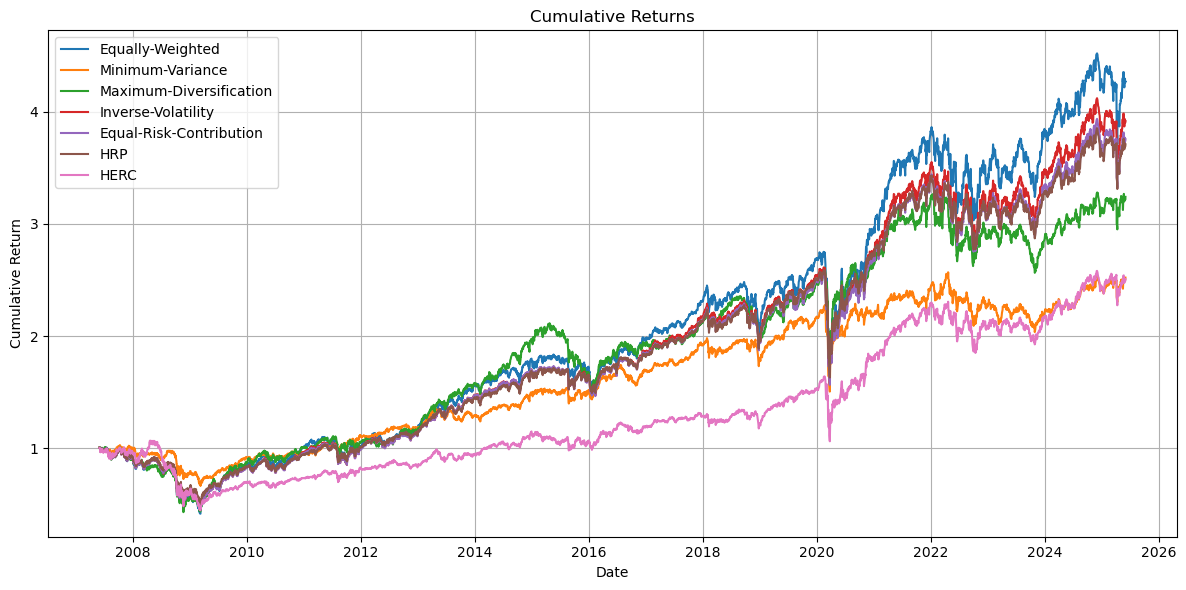

In [86]:
df_SP500_2jahre["Date"] = pd.to_datetime(df_SP500_2jahre["Date"])

#Date-Spalte als Index setzen
df_SP500_2jahre = df_SP500_2jahre.set_index("Date")

#Kumulierte Rendite berechnen (angenommen tägliche Returns)
#(1 + r).cumprod() - 1 ergibt den Gesamtzuwachs in Prozent
kumulative_returns = gesamt_return(df_SP500_2jahre)

#Plot
plt.figure(figsize=(12,6))
plt.plot(kumulative_returns)
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(kumulative_returns.columns, loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [87]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
sharpe_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(lambda y: sharpe_ratio(y) * np.sqrt(252)))

sharpe_jahresweise_2jahre

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.711107         -0.050838                -1.035990   
2008         -0.749493         -0.736699                -1.043773   
2009          1.199742          1.010867                 1.772764   
2010          0.988893          0.544724                 1.009516   
2011          0.131313          1.215963                 0.313387   
2012          1.166880          0.672980                 0.886390   
2013          2.521734          1.141404                 2.640766   
2014          1.102685          1.554010                 1.829896   
2015         -0.191520          0.179012                -0.961591   
2016          1.019914          1.217487                 1.157489   
2017          2.381229          2.296085                 1.256488   
2018         -0.486467         -0.444798                -0.397197   
2019          2.001248          2.194460                 2.220389   
2020          0.451171          0.193146                 0.369374   
2021          1.909161          1.044962                 1.734041   
2022         -0.412809         -0.400792                -0.476085   
2023          0.938538         -0.254585                -0.031972   
2024          0.916481          1.106836                 0.867478   
2025          0.219769          0.813017                 0.727684   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2007           -0.702411                -0.737579 -0.710345 -0.200160  
2008           -0.777146                -0.803397 -0.795767 -0.771259  
2009            1.154067                 1.174485  1.132290  0.576709  
2010            0.958048                 0.941021  0.900682  0.499846  
2011            0.253695                 0.285596  0.436093  0.774028  
2012            1.135191                 1.145116  1.169563  0.276194  
2013            2.465479                 2.508996  2.468088  1.179816  
2014            1.203508                 1.227520  1.336017  1.653733  
2015           -0.116067                -0.165190 -0.069435 -0.310183  
2016            0.971237                 0.964739  0.923928  1.007534  
2017            2.501313                 2.422346  2.571729  1.298896  
2018           -0.463785                -0.442449 -0.397614 -0.366920  
2019            2.128650                 2.132688  2.273530  2.553782  
2020            0.421168                 0.413786  0.436099  0.661772  
2021            1.982864                 2.002767  1.995616  1.968033  
2022           -0.430078                -0.432230 -0.457670 -0.395159  
2023            0.821682                 0.743692  0.613025  0.430970  
2024            1.020586                 1.011686  1.069085  1.184597  
2025            0.292567                 0.315217  0.402268  0.538432

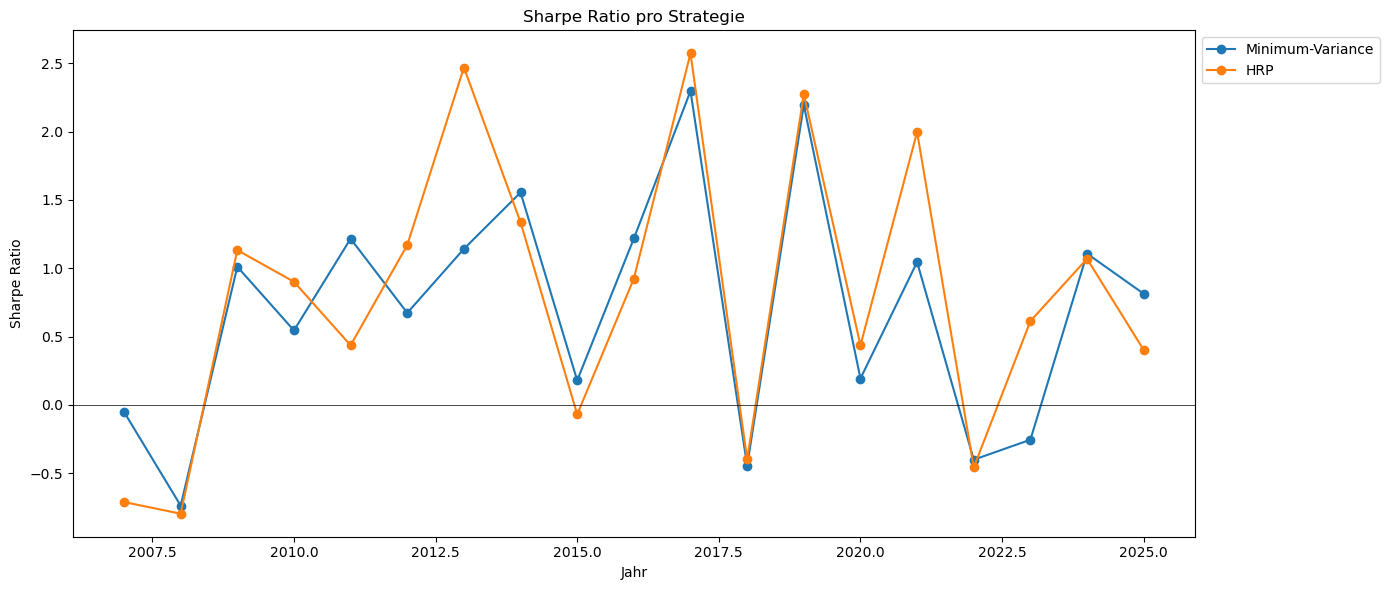

In [88]:
#Plotten der SR
strategien = sharpe_jahresweise_2jahre.columns
years = sharpe_jahresweise_2jahre.index

plt.figure(figsize=(14,6))

strategie = "Minimum-Variance"
plt.plot(years, sharpe_jahresweise_2jahre[strategie], label=strategie, marker='o')

strategie = "HRP"
plt.plot(years, sharpe_jahresweise_2jahre[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  
plt.xlabel("Jahr")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

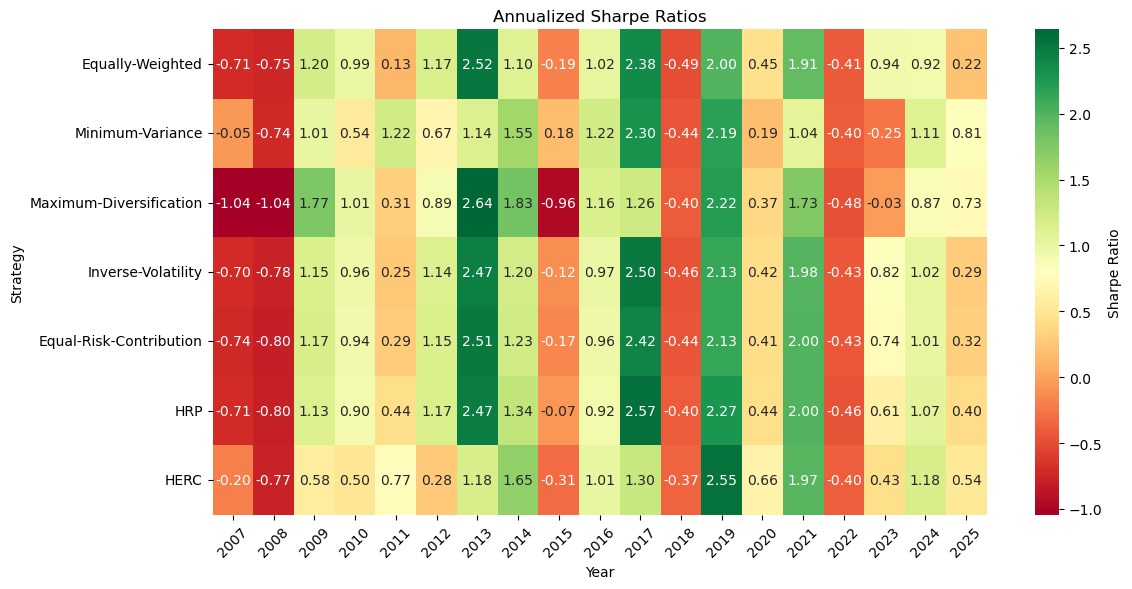

In [89]:
plt.figure(figsize=(12,6))
sb.heatmap(sharpe_jahresweise_2jahre.T,        
            annot=True,                  
            fmt=".2f",                   
            cmap="RdYlGn",               
            cbar_kws={'label': 'Sharpe Ratio'})  

plt.title("Annualized Sharpe Ratios")
plt.xlabel("Year")
plt.ylabel("Strategy")
plt.yticks(rotation=0)  
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [90]:
#Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
def sharpe_total_2jahre(returns_daily):
    mean_daily = returns_daily.mean()
    std_daily = returns_daily.std()
    return (mean_daily / std_daily) * np.sqrt(4529)  # 252 Handelstage

gesamt_sharpe_2jahre = df_SP500_2jahre.apply(sharpe_total_2jahre)

print(gesamt_sharpe_2jahre)

Equally-Weighted           2.023797
Minimum-Variance           1.858314
Maximum-Diversification    1.902009
Inverse-Volatility         2.027997
Equal-Risk-Contribution    2.000749
HRP                        2.097945
HERC                       1.542436
dtype: float64


In [91]:
#Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
def sharpe_annual_2jahre(returns_daily):
    mean_daily = returns_daily.mean()
    std_daily = returns_daily.std()
    return (mean_daily / std_daily) * np.sqrt(252)  # 252 Handelstage

annualized_sharpe_2jahre = df_SP500_2jahre.apply(sharpe_annual_2jahre)

print(annualized_sharpe_2jahre)

Equally-Weighted           0.477382
Minimum-Variance           0.438347
Maximum-Diversification    0.448654
Inverse-Volatility         0.478373
Equal-Risk-Contribution    0.471945
HRP                        0.494872
HERC                       0.363837
dtype: float64


In [92]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
sortino_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(lambda y: sortino_ratio(y) * np.sqrt(252)))

sortino_jahresweise_2jahre

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.942227         -0.070579                -1.368963   
2008         -1.031995         -1.040375                -1.380226   
2009          1.792430          1.461408                 2.617667   
2010          1.433364          0.774966                 1.420193   
2011          0.179212          1.771669                 0.429525   
2012          1.768386          0.968697                 1.319021   
2013          3.785806          1.665161                 4.130692   
2014          1.536686          2.339751                 2.725998   
2015         -0.264530          0.246666                -1.274654   
2016          1.444870          1.783023                 1.731413   
2017          3.728080          3.557362                 1.865231   
2018         -0.632529         -0.573613                -0.533265   
2019          2.880113          3.252337                 3.198674   
2020          0.618923          0.260618                 0.490175   
2021          2.858347          1.604942                 2.687537   
2022         -0.580638         -0.540367                -0.654417   
2023          1.399059         -0.344831                -0.043702   
2024          1.299432          1.595643                 1.250431   
2025          0.321831          1.159650                 1.054233   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2007           -0.930710                -0.972910 -0.940419 -0.265292  
2008           -1.073445                -1.106593 -1.102768 -1.078659  
2009            1.707341                 1.736618  1.662546  0.801186  
2010            1.383933                 1.356157  1.291323  0.706477  
2011            0.347027                 0.390794  0.597405  1.087474  
2012            1.713063                 1.727807  1.769612  0.406177  
2013            3.728781                 3.793388  3.753751  1.705022  
2014            1.691155                 1.725196  1.891325  2.433941  
2015           -0.160719                -0.228187 -0.096197 -0.418179  
2016            1.374735                 1.368677  1.312808  1.411187  
2017            3.948628                 3.804672  4.081826  1.894220  
2018           -0.600577                -0.574336 -0.513124 -0.471546  
2019            3.075268                 3.081711  3.332617  3.913642  
2020            0.574852                 0.562145  0.593853  0.938448  
2021            2.956853                 2.980509  2.952212  2.926180  
2022           -0.604259                -0.605442 -0.636722 -0.550627  
2023            1.211104                 1.090619  0.891618  0.626622  
2024            1.456720                 1.445532  1.532723  1.713387  
2025            0.425717                 0.458545  0.581776  0.749659

In [93]:
#Funktion für annualisierten Sharpe Ratio
def sortino_total_2jahre(returns_daily):
    zins_risikofrei = 0
    mean_daily = returns_daily.mean()
    temp = (np.minimum(0, returns_daily - zins_risikofrei))**2
    temp = np.mean(temp)
    downside_dev = np.sqrt(temp)
    return (mean_daily / downside_dev) * np.sqrt(4529)  # 252 Handelstage

#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
gesamt_sortino_2jahre = df_SP500_2jahre.apply(sortino_total_2jahre)

print(gesamt_sortino_2jahre)

Equally-Weighted           2.850727
Minimum-Variance           2.599708
Maximum-Diversification    2.630486
Inverse-Volatility         2.845977
Equal-Risk-Contribution    2.801597
HRP                        2.936415
HERC                       2.164330
dtype: float64


In [94]:
#Funktion für annualisierten Sharpe Ratio
def sortino_annual_2jahre(returns_daily):
    zins_risikofrei = 0
    mean_daily = returns_daily.mean()
    temp = (np.minimum(0, returns_daily - zins_risikofrei))**2
    temp = np.mean(temp)
    downside_dev = np.sqrt(temp)
    return (mean_daily / downside_dev) * np.sqrt(252)  # 252 Handelstage

#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
annualized_sortino_2jahre = df_SP500_2jahre.apply(sortino_annual_2jahre)

print(annualized_sortino_2jahre)

Equally-Weighted           0.672442
Minimum-Variance           0.613230
Maximum-Diversification    0.620490
Inverse-Volatility         0.671321
Equal-Risk-Contribution    0.660853
HRP                        0.692654
HERC                       0.510532
dtype: float64


In [95]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
max_drawdown_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(maximum_drawdown))

max_drawdown_jahresweise_2jahre

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.121692         -0.056092                -0.115926   
2008         -0.508050         -0.277798                -0.521048   
2009         -0.331498         -0.165096                -0.238497   
2010         -0.164891         -0.061272                -0.106875   
2011         -0.223989         -0.090403                -0.145161   
2012         -0.108094         -0.051315                -0.070831   
2013         -0.064347         -0.086073                -0.059566   
2014         -0.077987         -0.043034                -0.060671   
2015         -0.127607         -0.092384                -0.231780   
2016         -0.098420         -0.106353                -0.077252   
2017         -0.029098         -0.031813                -0.039611   
2018         -0.196115         -0.126222                -0.194924   
2019         -0.070498         -0.049890                -0.058773   
2020         -0.405312         -0.339352                -0.341958   
2021         -0.063425         -0.071934                -0.068123   
2022         -0.215121         -0.185933                -0.196976   
2023         -0.138616         -0.124648                -0.145532   
2024         -0.073049         -0.050134                -0.064682   
2025         -0.158745         -0.081213                -0.086717   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2007           -0.115999                -0.117111 -0.104675 -0.100627  
2008           -0.466668                -0.469565 -0.418780 -0.547824  
2009           -0.297324                -0.293949 -0.262893 -0.302811  
2010           -0.144463                -0.141733 -0.124460 -0.079288  
2011           -0.190022                -0.183266 -0.156403 -0.129039  
2012           -0.086903                -0.083102 -0.063008 -0.087623  
2013           -0.063436                -0.062913 -0.062775 -0.113552  
2014           -0.070631                -0.070734 -0.063759 -0.066488  
2015           -0.117304                -0.119055 -0.109513 -0.144412  
2016           -0.087398                -0.085656 -0.074325 -0.079866  
2017           -0.026444                -0.024162 -0.021943 -0.037828  
2018           -0.183521                -0.182820 -0.170888 -0.125446  
2019           -0.060585                -0.058810 -0.051840 -0.035045  
2020           -0.395088                -0.389218 -0.370171 -0.352794  
2021           -0.057583                -0.056453 -0.055253 -0.052773  
2022           -0.206128                -0.200219 -0.192650 -0.198021  
2023           -0.130264                -0.127309 -0.121446 -0.109916  
2024           -0.072650                -0.071373 -0.066881 -0.070227  
2025           -0.141320                -0.135505 -0.123874 -0.110130

In [96]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
max_drawdown_total_2jahre = df_SP500_2jahre.apply(maximum_drawdown)

max_drawdown_total_2jahre.info

<bound method Series.info of Equally-Weighted          -0.586752
Minimum-Variance          -0.351771
Maximum-Diversification   -0.575154
Inverse-Volatility        -0.551797
Equal-Risk-Contribution   -0.552924
HRP                       -0.508614
HERC                      -0.581848
dtype: float64>

In [97]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
calmar_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(calmar_ratio_total))

calmar_jahresweise_2jahre.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.736132         -0.141603                -0.879619   
2008         -0.698769         -0.734386                -0.730804   
2009          1.307877          0.922095                 2.324065   
2010          1.180693          0.904266                 1.561433   
2011          0.003353          1.734435                 0.289904   
2012          1.494309          0.940865                 1.398757   
2013          5.324510          1.308190                 6.205391   
2014          1.648145          3.209327                 3.802932   
2015         -0.318565          0.159645                -0.646258   
2016          1.501362          1.187335                 2.024966   
2017          6.267379          4.326958                 2.651388   
2018         -0.423660         -0.461638                -0.311618   
20

In [98]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
calmar_total_2_2jahre = df_SP500_2jahre.apply(calmar_ratio_total)

calmar_total_2_2jahre.info

<bound method Series.info of Equally-Weighted           5.575748
Minimum-Variance           4.324408
Maximum-Diversification    3.896720
Inverse-Volatility         5.288317
Equal-Risk-Contribution    4.983721
HRP                        5.328267
HERC                       2.592027
dtype: float64>

In [99]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
var_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(value_at_risk_func))

var_jahresweise_2jahre

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.024115         -0.013130                -0.018114   
2008         -0.047373         -0.028052                -0.047553   
2009         -0.034898         -0.016545                -0.027475   
2010         -0.019303         -0.010704                -0.018158   
2011         -0.027031         -0.011150                -0.019340   
2012         -0.013024         -0.007584                -0.010316   
2013         -0.012277         -0.009880                -0.011312   
2014         -0.012269         -0.009115                -0.011475   
2015         -0.015920         -0.013038                -0.015276   
2016         -0.015390         -0.010857                -0.013138   
2017         -0.006141         -0.005606                -0.008572   
2018         -0.019558         -0.013332                -0.014475   
2019         -0.011964         -0.008532                -0.008941   
2020         -0.035786         -0.021747                -0.023932   
2021         -0.013644         -0.009457                -0.010315   
2022         -0.023224         -0.014825                -0.020840   
2023         -0.014323         -0.010255                -0.011991   
2024         -0.011380         -0.008706                -0.009897   
2025         -0.019056         -0.011182                -0.012224   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2007           -0.023334                -0.023217 -0.021121 -0.024808  
2008           -0.042880                -0.042270 -0.038287 -0.044233  
2009           -0.028807                -0.028639 -0.024651 -0.027206  
2010           -0.017536                -0.017372 -0.015334 -0.014288  
2011           -0.023651                -0.023050 -0.019505 -0.015278  
2012           -0.011391                -0.011194 -0.010303 -0.008830  
2013           -0.010838                -0.010656 -0.009804 -0.011124  
2014           -0.011170                -0.011098 -0.010627 -0.010604  
2015           -0.015818                -0.015501 -0.015242 -0.014517  
2016           -0.014258                -0.013972 -0.013834 -0.013979  
2017           -0.005858                -0.005633 -0.005487 -0.006332  
2018           -0.018796                -0.018126 -0.017316 -0.013079  
2019           -0.010751                -0.010482 -0.009949 -0.008628  
2020           -0.032294                -0.031307 -0.030315 -0.026436  
2021           -0.012697                -0.012234 -0.011851 -0.012030  
2022           -0.022037                -0.021721 -0.019958 -0.019891  
2023           -0.013828                -0.013289 -0.012433 -0.012446  
2024           -0.009869                -0.009464 -0.009659 -0.009219  
2025           -0.018149                -0.017774 -0.016644 -0.017743

In [100]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
var_total_2jahre = df_SP500_2jahre.apply(value_at_risk_func)

var_total_2jahre.info

<bound method Series.info of Equally-Weighted          -0.020126
Minimum-Variance          -0.012004
Maximum-Diversification   -0.016502
Inverse-Volatility        -0.018546
Equal-Risk-Contribution   -0.018109
HRP                       -0.016653
HERC                      -0.016621
dtype: float64>

In [101]:
monthly_returns_2jahre = df_SP500_2jahre.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_var_2jahre = monthly_returns_2jahre.apply(value_at_risk_func)

monthly_var_2jahre.info

<bound method Series.info of Equally-Weighted          -0.082992
Minimum-Variance          -0.048859
Maximum-Diversification   -0.067668
Inverse-Volatility        -0.071059
Equal-Risk-Contribution   -0.070017
HRP                       -0.062918
HERC                      -0.070195
dtype: float64>

In [102]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
es_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(expected_shortfall))

es_jahresweise_2jahre

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.027957         -0.016510                -0.021735   
2008         -0.069253         -0.040512                -0.064436   
2009         -0.048986         -0.021003                -0.036962   
2010         -0.029395         -0.016209                -0.025022   
2011         -0.038600         -0.017327                -0.027919   
2012         -0.018413         -0.010333                -0.014647   
2013         -0.016677         -0.013322                -0.016400   
2014         -0.017509         -0.011290                -0.016041   
2015         -0.022182         -0.018441                -0.023234   
2016         -0.022053         -0.013713                -0.016697   
2017         -0.009565         -0.007265                -0.010869   
2018         -0.025467         -0.019813                -0.020912   
2019         -0.019290         -0.012591                -0.015011   
2020         -0.062400         -0.050066                -0.052433   
2021         -0.019186         -0.013455                -0.015625   
2022         -0.031274         -0.021725                -0.026725   
2023         -0.017568         -0.013894                -0.015623   
2024         -0.016383         -0.011482                -0.013616   
2025         -0.033037         -0.018607                -0.021401   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2007           -0.027098                -0.026745 -0.024740 -0.029725  
2008           -0.062821                -0.062351 -0.055453 -0.066434  
2009           -0.041368                -0.040890 -0.034413 -0.040326  
2010           -0.026305                -0.025979 -0.023405 -0.020289  
2011           -0.034997                -0.034161 -0.030212 -0.024769  
2012           -0.016386                -0.016001 -0.013716 -0.010659  
2013           -0.015540                -0.015401 -0.014493 -0.015689  
2014           -0.016475                -0.016504 -0.015627 -0.014022  
2015           -0.021354                -0.021343 -0.020637 -0.022912  
2016           -0.020343                -0.020082 -0.018446 -0.018946  
2017           -0.008861                -0.008747 -0.008323 -0.008707  
2018           -0.024600                -0.024052 -0.023562 -0.020603  
2019           -0.017976                -0.017242 -0.015994 -0.012774  
2020           -0.060688                -0.059512 -0.056726 -0.055810  
2021           -0.018050                -0.017330 -0.016373 -0.017336  
2022           -0.029244                -0.028382 -0.026790 -0.026469  
2023           -0.016722                -0.016067 -0.015250 -0.014785  
2024           -0.014847                -0.014275 -0.013086 -0.013706  
2025           -0.030394                -0.029507 -0.026935 -0.026280

In [103]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
es_total_2jahre = df_SP500_2jahre.apply(expected_shortfall)

es_total_2jahre.info

<bound method Series.info of Equally-Weighted          -0.033841
Minimum-Variance          -0.020270
Maximum-Diversification   -0.027896
Inverse-Volatility        -0.030892
Equal-Risk-Contribution   -0.030328
HRP                       -0.027537
HERC                      -0.029088
dtype: float64>

In [104]:
monthly_returns_2jahre = df_SP500_2jahre.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_es_2jahre  = monthly_returns_2jahre.apply(expected_shortfall)

monthly_es_2jahre.info

<bound method Series.info of Equally-Weighted          -0.114893
Minimum-Variance          -0.075164
Maximum-Diversification   -0.104110
Inverse-Volatility        -0.105665
Equal-Risk-Contribution   -0.104438
HRP                       -0.095282
HERC                      -0.105268
dtype: float64>

In [105]:
yearly_returns_2jahre = df_SP500_2jahre.resample('Y').apply(lambda x: (1 + x).prod() - 1)
yearly_es_2jahre  = yearly_returns_2jahre.apply(expected_shortfall)

yearly_es_2jahre.info

<bound method Series.info of Equally-Weighted          -0.355010
Minimum-Variance          -0.204011
Maximum-Diversification   -0.380784
Inverse-Volatility        -0.330199
Equal-Risk-Contribution   -0.333025
HRP                       -0.296676
HERC                      -0.361127
dtype: float64>

In [106]:
#Zusammenfassung der Metriken
Zusammenfassung_2jahre = pd.concat([annualized_sharpe_2jahre, annualized_sortino_2jahre, max_drawdown_total_2jahre, calmar_total_2_2jahre, monthly_var_2jahre, monthly_es_2jahre], axis=1)
Zusammenfassung_2jahre.columns = ["Sharpe", "Sortino", "Max Drawdown", "Calmar", "Var", "ES"]
print(Zusammenfassung_2jahre)

                           Sharpe   Sortino  Max Drawdown    Calmar       Var  \
Equally-Weighted         0.477382  0.672442     -0.586752  5.575748 -0.082992   
Minimum-Variance         0.438347  0.613230     -0.351771  4.324408 -0.048859   
Maximum-Diversification  0.448654  0.620490     -0.575154  3.896720 -0.067668   
Inverse-Volatility       0.478373  0.671321     -0.551797  5.288317 -0.071059   
Equal-Risk-Contribution  0.471945  0.660853     -0.552924  4.983721 -0.070017   
HRP                      0.494872  0.692654     -0.508614  5.328267 -0.062918   
HERC                     0.363837  0.510532     -0.581848  2.592027 -0.070195   

                               ES  
Equally-Weighted        -0.114893  
Minimum-Variance        -0.075164  
Maximum-Diversification -0.104110  
Inverse-Volatility      -0.105665  
Equal-Risk-Contribution -0.104438  
HRP                     -0.095282  
HERC                    -0.105268  


## S&P 500 2Jahre Shrinked

In [107]:
#Bearbeitete SP500-Daten (Gesamtbestand, 2 Jahre)

df_SP500_2jahre_shrinked = pd.read_csv(
    'returnssp500shrinked_neu_2jahre_f.csv',
    sep=',',
    encoding='utf-8',
    index_col=0,
    decimal = '.',
    low_memory=False,
    parse_dates=['Date'],
    dayfirst=True
)

In [108]:
df_SP500_2jahre_shrinked.info

<bound method DataFrame.info of             Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0     2007-06-01          0.004099          0.005562                 0.007957   
1     2007-06-04          0.001869         -0.001356                 0.000403   
2     2007-06-05         -0.006664         -0.008619                -0.007702   
3     2007-06-06         -0.009787         -0.006710                -0.007512   
4     2007-06-07         -0.019440         -0.013489                -0.013079   
...          ...               ...               ...                      ...   
4524  2025-05-23         -0.003445          0.001881                 0.001322   
4525  2025-05-27          0.018291          0.010747                 0.009686   
4526  2025-05-28         -0.008780         -0.004960                -0.006235   
4527  2025-05-29          0.003932          0.002323                 0.001627   
4528  2025-05-30         -0.000518          0.006359                 0.006522

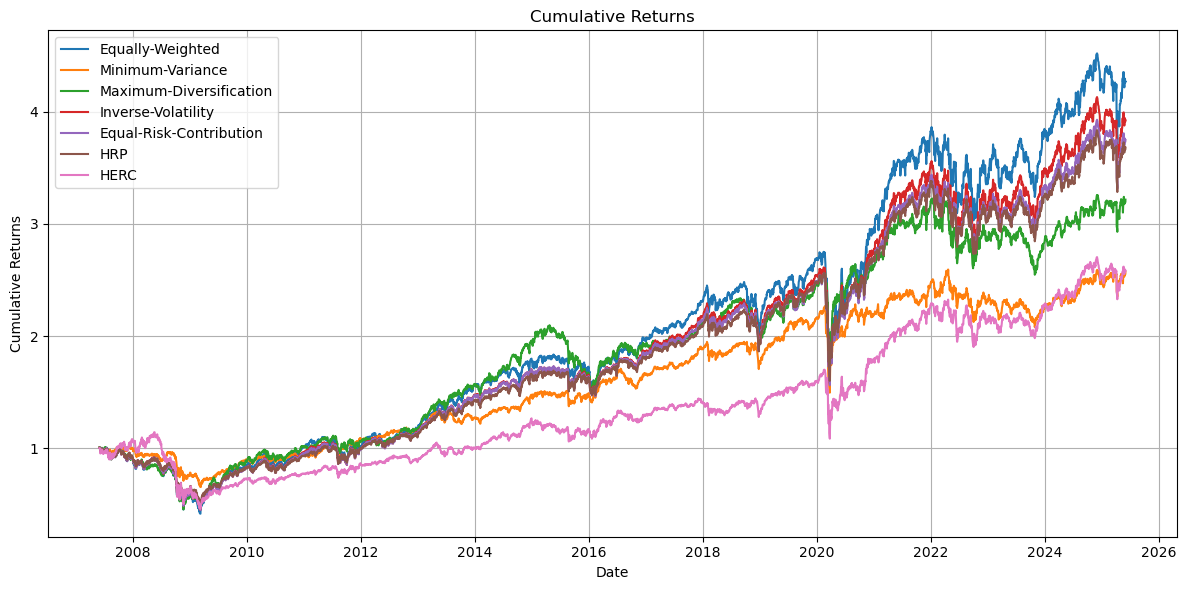

In [109]:
df_SP500_2jahre_shrinked["Date"] = pd.to_datetime(df_SP500_2jahre_shrinked["Date"])

#Date-Spalte als Index setzen
df_SP500_2jahre_shrinked = df_SP500_2jahre_shrinked.set_index("Date")

#Kumulierte Rendite berechnen (angenommen tägliche Returns)
#(1 + r).cumprod() - 1 ergibt den Gesamtzuwachs in Prozent
kumulative_returns = gesamt_return(df_SP500_2jahre_shrinked)

#Plot
plt.figure(figsize=(12,6))
plt.plot(kumulative_returns)
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend(kumulative_returns.columns, loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [110]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
sharpe_jahresweise_2jahre_shrinked = df_SP500_2jahre_shrinked.groupby(df_SP500_2jahre_shrinked.index.year).apply(lambda x: x.apply(lambda y: sharpe_ratio(y) * np.sqrt(252)))

sharpe_jahresweise_2jahre_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.711107         -0.085458                -1.009551   
2008         -0.749493         -0.801848                -1.013996   
2009          1.199742          0.998864                 1.784231   
2010          0.988893          0.560416                 0.988828   
2011          0.131313          1.185722                 0.308437   
2012          1.166880          0.713185                 0.886298   
2013          2.521734          1.208615                 2.617958   
2014          1.102685          1.571904                 1.828136   
2015         -0.191520          0.147185                -0.935728   
2016          1.019914          1.223586                 1.151930   
2017          2.381229          2.313398                 1.257750   
2018         -0.486467         -0.424262                -0.374686   
2019          2.001248          2.351433                 2.216247   
2020          0.451171          0.197283                 0.363175   
2021          1.909161          1.213745                 1.743403   
2022         -0.412809         -0.375509                -0.471986   
2023          0.938538         -0.214363                -0.037641   
2024          0.916481          1.115554                 0.894993   
2025          0.219769          0.756006                 0.696576   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2007           -0.704316                -0.737625 -0.745060  0.590557  
2008           -0.776652                -0.804818 -0.811031 -0.768154  
2009            1.154361                 1.174556  1.133324  0.658552  
2010            0.959967                 0.941054  0.880022  0.563775  
2011            0.250626                 0.285506  0.444372  0.729605  
2012            1.136719                 1.146369  1.136562  0.401925  
2013            2.468448                 2.509014  2.471243  1.190751  
2014            1.199077                 1.227544  1.339967  1.992047  
2015           -0.118682                -0.165251 -0.049332 -0.330797  
2016            0.971762                 0.967808  0.911473  0.923482  
2017            2.499625                 2.425246  2.464963  1.452610  
2018           -0.467271                -0.451140 -0.345738 -0.435082  
2019            2.122192                 2.132724  2.296900  2.040881  
2020            0.424646                 0.412821  0.420867  0.503463  
2021            1.980174                 2.007181  2.015144  1.961089  
2022           -0.429752                -0.436304 -0.437584 -0.219272  
2023            0.824843                 0.743778  0.624933  0.576401  
2024            1.017461                 1.011640  1.102174  1.169972  
2025            0.288683                 0.315211  0.371009  0.384277

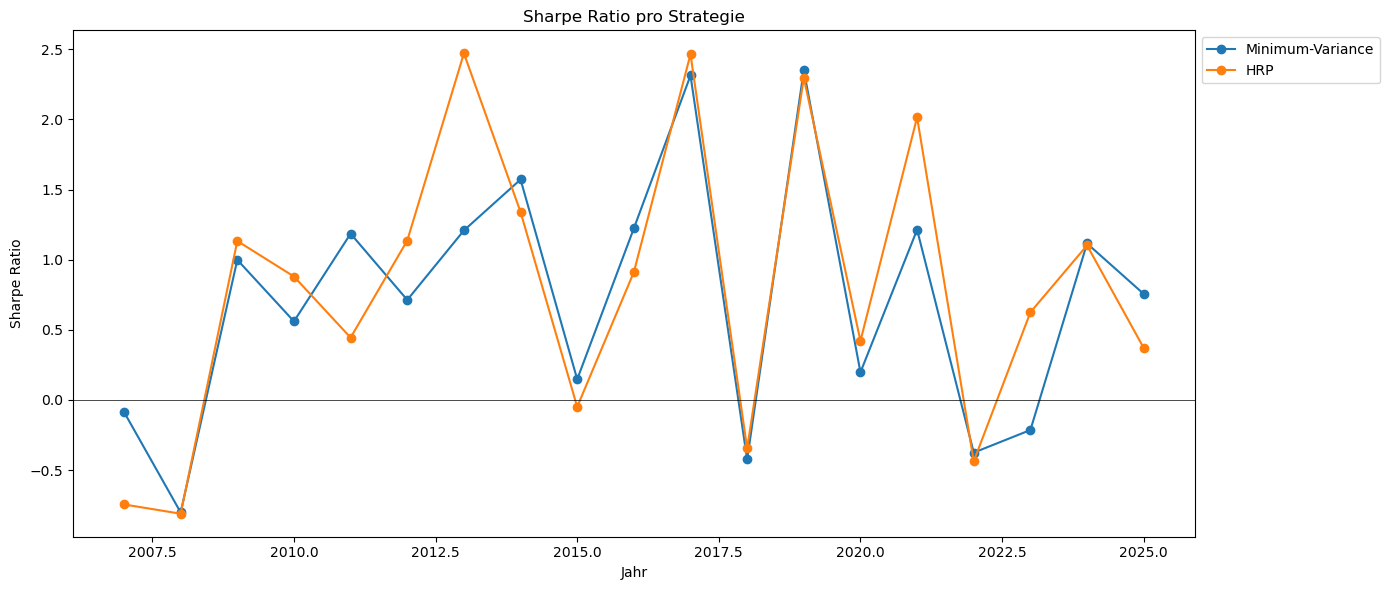

In [111]:
#Plotten der SR
strategien = sharpe_jahresweise_2jahre_shrinked.columns
years = sharpe_jahresweise_2jahre_shrinked.index

plt.figure(figsize=(14,6))

strategie = "Minimum-Variance"
plt.plot(years, sharpe_jahresweise_2jahre_shrinked[strategie], label=strategie, marker='o')

strategie = "HRP"
plt.plot(years, sharpe_jahresweise_2jahre_shrinked[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  
plt.xlabel("Jahr")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [112]:
gesamt_sharpe_2jahre_shrinked = df_SP500_2jahre_shrinked.apply(sharpe_annual_2jahre)

print(gesamt_sharpe_2jahre_shrinked)

Equally-Weighted           0.477382
Minimum-Variance           0.446857
Maximum-Diversification    0.452980
Inverse-Volatility         0.477803
Equal-Risk-Contribution    0.471242
HRP                        0.491451
HERC                       0.363484
dtype: float64


In [113]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
sortino_jahresweise_2jahre_shrinked = df_SP500_2jahre_shrinked.groupby(df_SP500_2jahre_shrinked.index.year).apply(lambda x: x.apply(lambda y: sortino_ratio(y) * np.sqrt(252)))

sortino_jahresweise_2jahre_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.942227         -0.118612                -1.336208   
2008         -1.031995         -1.127446                -1.345535   
2009          1.792430          1.436601                 2.631072   
2010          1.433364          0.797547                 1.392690   
2011          0.179212          1.721112                 0.422772   
2012          1.768386          1.033748                 1.318194   
2013          3.785806          1.760765                 4.089579   
2014          1.536686          2.365539                 2.720154   
2015         -0.264530          0.202751                -1.241978   
2016          1.444870          1.792160                 1.722618   
2017          3.728080          3.588155                 1.869434   
2018         -0.632529         -0.546350                -0.501539   
2019          2.880113          3.521251                 3.194390   
2020          0.618923          0.265614                 0.481073   
2021          2.858347          1.848780                 2.693511   
2022         -0.580638         -0.507003                -0.648732   
2023          1.399059         -0.290623                -0.051420   
2024          1.299432          1.609483                 1.293200   
2025          0.321831          1.077165                 1.009320   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2007           -0.933106                -0.972976 -0.984245  0.802118  
2008           -1.072438                -1.108551 -1.124005 -1.063340  
2009            1.708138                 1.736724  1.665363  0.912389  
2010            1.386981                 1.356199  1.261033  0.798985  
2011            0.342797                 0.390676  0.609418  1.019014  
2012            1.715546                 1.729889  1.715124  0.586457  
2013            3.732445                 3.793409  3.765598  1.731254  
2014            1.684255                 1.725225  1.894691  3.004791  
2015           -0.164322                -0.228271 -0.068475 -0.449611  
2016            1.375402                 1.373257  1.293558  1.284594  
2017            3.945449                 3.812633  3.894372  2.139126  
2018           -0.605190                -0.586319 -0.447492 -0.566408  
2019            3.065105                 3.081786  3.363191  3.028813  
2020            0.579871                 0.560895  0.570235  0.700020  
2021            2.953740                 2.988195  2.995556  2.874222  
2022           -0.603841                -0.610955 -0.610945 -0.306273  
2023            1.216095                 1.090760  0.909528  0.857847  
2024            1.452065                 1.445463  1.581046  1.705449  
2025            0.420251                 0.458540  0.536778  0.535186

In [114]:
#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
gesamt_sortino_2jahre_shrinked = df_SP500_2jahre_shrinked.apply(sortino_annual_2jahre)

print(gesamt_sortino_2jahre_shrinked)

Equally-Weighted           0.672442
Minimum-Variance           0.623923
Maximum-Diversification    0.626449
Inverse-Volatility         0.670601
Equal-Risk-Contribution    0.659896
HRP                        0.687424
HERC                       0.506882
dtype: float64


In [115]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
max_drawdown_jahresweise_2jahre_shrinked = df_SP500_2jahre_shrinked.groupby(df_SP500_2jahre_shrinked.index.year).apply(lambda x: x.apply(maximum_drawdown))

max_drawdown_jahresweise_2jahre_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.121692         -0.056523                -0.111399   
2008         -0.508050         -0.290618                -0.495919   
2009         -0.331498         -0.164960                -0.228435   
2010         -0.164891         -0.065018                -0.103375   
2011         -0.223989         -0.089531                -0.143471   
2012         -0.108094         -0.049697                -0.064619   
2013         -0.064347         -0.082254                -0.059630   
2014         -0.077987         -0.042968                -0.060492   
2015         -0.127607         -0.092364                -0.227392   
2016         -0.098420         -0.104546                -0.076608   
2017         -0.029098         -0.031800                -0.039129   
2018         -0.196115         -0.124598                -0.189473   
2019         -0.070498         -0.048241                -0.058119   
2020         -0.405312         -0.340528                -0.342420   
2021         -0.063425         -0.063758                -0.066312   
2022         -0.215121         -0.180305                -0.193161   
2023         -0.138616         -0.121286                -0.145275   
2024         -0.073049         -0.049693                -0.063157   
2025         -0.158745         -0.082959                -0.087010   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2007           -0.116472                -0.117112 -0.106789 -0.100954  
2008           -0.469655                -0.470120 -0.423288 -0.560630  
2009           -0.298968                -0.294035 -0.265178 -0.301187  
2010           -0.145325                -0.141749 -0.124932 -0.079946  
2011           -0.191041                -0.183280 -0.155982 -0.125719  
2012           -0.087423                -0.083109 -0.063543 -0.080890  
2013           -0.063426                -0.062912 -0.061422 -0.117563  
2014           -0.070957                -0.070736 -0.064397 -0.067073  
2015           -0.117605                -0.119057 -0.108575 -0.150667  
2016           -0.087750                -0.085667 -0.075020 -0.079522  
2017           -0.026551                -0.024141 -0.022670 -0.038042  
2018           -0.184507                -0.185293 -0.167872 -0.114954  
2019           -0.060946                -0.058806 -0.051145 -0.035519  
2020           -0.395379                -0.389223 -0.375158 -0.361647  
2021           -0.057863                -0.056444 -0.056617 -0.053467  
2022           -0.206617                -0.200618 -0.192425 -0.181711  
2023           -0.130412                -0.127312 -0.122854 -0.102367  
2024           -0.072722                -0.071373 -0.067416 -0.075786  
2025           -0.142280                -0.135513 -0.124679 -0.120187

In [116]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
max_drawdown_total_2jahre_shrinked = df_SP500_2jahre_shrinked.apply(maximum_drawdown)

max_drawdown_total_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.586752
Minimum-Variance          -0.362550
Maximum-Diversification   -0.550831
Inverse-Volatility        -0.553951
Equal-Risk-Contribution   -0.553317
HRP                       -0.514763
HERC                      -0.597143
dtype: float64>

In [117]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
calmar_jahresweise_2jahre_shrinked = df_SP500_2jahre_shrinked.groupby(df_SP500_2jahre_shrinked.index.year).apply(lambda x: x.apply(calmar_ratio_total))

calmar_jahresweise_2jahre_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.736132         -0.185067                -0.883083   
2008         -0.698769         -0.747016                -0.726403   
2009          1.307877          0.898173                 2.289995   
2010          1.180693          0.878760                 1.520481   
2011          0.003353          1.703938                 0.283592   
2012          1.494309          1.023851                 1.488225   
2013          5.324510          1.452146                 5.983577   
2014          1.648145          3.242765                 3.770557   
2015         -0.318565          0.115422                -0.640001   
2016          1.501362          1.209043                 2.018494   
2017          6.267379          4.352827                 2.661526   
2018         -0.423660         -0.447973                -0.302189   
2019          3.852527          4.554181                 4.200614   
2020          0.258278          0.041805                 0.193091   
2021          4.525968          1.994090                 3.258043   
2022         -0.520242         -0.362811                -0.531146   
2023          0.933345         -0.210548                -0.073103   
2024          1.412977          1.859267                 1.355916   
2025          0.062017          0.512383                 0.487404   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2007           -0.735293                -0.746907 -0.760940  0.650601  
2008           -0.706861                -0.709519 -0.713568 -0.730297  
2009            1.154540                 1.174658  1.048790  0.484770  
2010            1.156763                 1.136358  1.065635  0.854110  
2011            0.165399                 0.215928  0.453194  0.909956  
2012            1.587401                 1.645528  1.842913  0.386853  
2013            4.920842                 4.980419  4.706883  1.160664  
2014            1.884446                 1.938508  2.232656  3.302047  
2015           -0.244315                -0.296697 -0.162673 -0.400088  
2016            1.481680                 1.492201  1.493777  1.507332  
2017            6.702287                 6.980896  7.249292  2.442476  
2018           -0.415369                -0.396866 -0.336809 -0.530722  
2019            4.427185                 4.423980  5.163593  5.819406  
2020            0.234083                 0.224051  0.237991  0.340527  
2021            4.728150                 4.687321  4.389596  4.992592  
2022           -0.521974                -0.525558 -0.516428 -0.336355  
2023            0.802231                 0.703317  0.560393  0.598709  
2024            1.491068                 1.457296  1.588038  1.497969  
2025            0.112491                 0.133393  0.177297  0.182927

In [118]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
calmar_total_2_2jahre_shrinked = df_SP500_2jahre_shrinked.apply(calmar_ratio_total)

calmar_total_2_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted           5.575748
Minimum-Variance           4.331719
Maximum-Diversification    4.023844
Inverse-Volatility         5.282523
Equal-Risk-Contribution    4.966473
HRP                        5.207045
HERC                       2.653987
dtype: float64>

In [119]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
var_jahresweise_2jahre_shrinked = df_SP500_2jahre_shrinked.groupby(df_SP500_2jahre_shrinked.index.year).apply(lambda x: x.apply(value_at_risk_func))

var_jahresweise_2jahre_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.024115         -0.013020                -0.017959   
2008         -0.047373         -0.027462                -0.044971   
2009         -0.034898         -0.015537                -0.026092   
2010         -0.019303         -0.010441                -0.017310   
2011         -0.027031         -0.011254                -0.019240   
2012         -0.013024         -0.007163                -0.010288   
2013         -0.012277         -0.010028                -0.010997   
2014         -0.012269         -0.009126                -0.011402   
2015         -0.015920         -0.013084                -0.015179   
2016         -0.015390         -0.010598                -0.012986   
2017         -0.006141         -0.005633                -0.008499   
2018         -0.019558         -0.013430                -0.014698   
2019         -0.011964         -0.008590                -0.008893   
2020         -0.035786         -0.021528                -0.023610   
2021         -0.013644         -0.009499                -0.010517   
2022         -0.023224         -0.015046                -0.020560   
2023         -0.014323         -0.010229                -0.012032   
2024         -0.011380         -0.008534                -0.009794   
2025         -0.019056         -0.011344                -0.012524   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2007           -0.023393                -0.023217 -0.021128 -0.025445  
2008           -0.043293                -0.042275 -0.038634 -0.053483  
2009           -0.029023                -0.028647 -0.025117 -0.029223  
2010           -0.017620                -0.017375 -0.015406 -0.014139  
2011           -0.023750                -0.023052 -0.019524 -0.015961  
2012           -0.011426                -0.011222 -0.010237 -0.008876  
2013           -0.010868                -0.010656 -0.009702 -0.010619  
2014           -0.011217                -0.011100 -0.010656 -0.010688  
2015           -0.015806                -0.015499 -0.015286 -0.016243  
2016           -0.014273                -0.013973 -0.013803 -0.014944  
2017           -0.005863                -0.005557 -0.005431 -0.006201  
2018           -0.018852                -0.018125 -0.016982 -0.012282  
2019           -0.010818                -0.010483 -0.009850 -0.008991  
2020           -0.032458                -0.031307 -0.030260 -0.027989  
2021           -0.012744                -0.012242 -0.011769 -0.011847  
2022           -0.022102                -0.021751 -0.019691 -0.020038  
2023           -0.013846                -0.013290 -0.012304 -0.011356  
2024           -0.009927                -0.009464 -0.009567 -0.008827  
2025           -0.018253                -0.017775 -0.016970 -0.017088

In [120]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
var_total_2jahre_shrinked = df_SP500_2jahre_shrinked.apply(value_at_risk_func)

var_total_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.020126
Minimum-Variance          -0.012091
Maximum-Diversification   -0.016112
Inverse-Volatility        -0.018596
Equal-Risk-Contribution   -0.018089
HRP                       -0.016540
HERC                      -0.017072
dtype: float64>

In [121]:
monthly_returns_2jahre_shrinked = df_SP500_2jahre_shrinked.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_var_2jahre_shrinked = monthly_returns_2jahre_shrinked.apply(value_at_risk_func)

monthly_var_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.082992
Minimum-Variance          -0.048125
Maximum-Diversification   -0.064825
Inverse-Volatility        -0.071532
Equal-Risk-Contribution   -0.070088
HRP                       -0.063900
HERC                      -0.074144
dtype: float64>

In [122]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
es_jahresweise_2jahre_shrinked = df_SP500_2jahre_shrinked.groupby(df_SP500_2jahre_shrinked.index.year).apply(lambda x: x.apply(expected_shortfall))

es_jahresweise_2jahre_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.027957         -0.016468                -0.021445   
2008         -0.069253         -0.040632                -0.061535   
2009         -0.048986         -0.020770                -0.034974   
2010         -0.029395         -0.016123                -0.024098   
2011         -0.038600         -0.017476                -0.027409   
2012         -0.018413         -0.010077                -0.014243   
2013         -0.016677         -0.013434                -0.016030   
2014         -0.017509         -0.011320                -0.015966   
2015         -0.022182         -0.018483                -0.023116   
2016         -0.022053         -0.013671                -0.016603   
2017         -0.009565         -0.007249                -0.010810   
2018         -0.025467         -0.019861                -0.020937   
2019         -0.019290         -0.012462                -0.014912   
2020         -0.062400         -0.050316                -0.052331   
2021         -0.019186         -0.013441                -0.015279   
2022         -0.031274         -0.021550                -0.026266   
2023         -0.017568         -0.013832                -0.015562   
2024         -0.016383         -0.011436                -0.013388   
2025         -0.033037         -0.018800                -0.021238   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2007           -0.027153                -0.026744 -0.024834 -0.031371  
2008           -0.063240                -0.062371 -0.055752 -0.080122  
2009           -0.041708                -0.040900 -0.034543 -0.040751  
2010           -0.026430                -0.025983 -0.023297 -0.020080  
2011           -0.035105                -0.034162 -0.030154 -0.024838  
2012           -0.016443                -0.016003 -0.013693 -0.010896  
2013           -0.015575                -0.015401 -0.014425 -0.015756  
2014           -0.016517                -0.016505 -0.015716 -0.013684  
2015           -0.021378                -0.021344 -0.020550 -0.022325  
2016           -0.020395                -0.020083 -0.018556 -0.019311  
2017           -0.008888                -0.008754 -0.008318 -0.008504  
2018           -0.024662                -0.024132 -0.023437 -0.019741  
2019           -0.018041                -0.017242 -0.015974 -0.013630  
2020           -0.060769                -0.059556 -0.057344 -0.057242  
2021           -0.018113                -0.017323 -0.016300 -0.018401  
2022           -0.029331                -0.028427 -0.026640 -0.027409  
2023           -0.016743                -0.016066 -0.015222 -0.014482  
2024           -0.014896                -0.014275 -0.013089 -0.012938  
2025           -0.030562                -0.029508 -0.027138 -0.024715

In [123]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
es_total_2jahre_shrinked = df_SP500_2jahre_shrinked.apply(expected_shortfall)

es_total_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.033841
Minimum-Variance          -0.020267
Maximum-Diversification   -0.027148
Inverse-Volatility        -0.031028
Equal-Risk-Contribution   -0.030344
HRP                       -0.027600
HERC                      -0.030511
dtype: float64>

In [124]:
monthly_returns_2jahre_shrinked = df_SP500_2jahre_shrinked.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_es_2jahre_shrinked  = monthly_returns_2jahre_shrinked.apply(expected_shortfall)

monthly_es_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.114893
Minimum-Variance          -0.076199
Maximum-Diversification   -0.100035
Inverse-Volatility        -0.106138
Equal-Risk-Contribution   -0.104597
HRP                       -0.095927
HERC                      -0.110014
dtype: float64>

In [125]:
yearly_returns_2jahre_shrinked = df_SP500_2jahre_shrinked.resample('Y').apply(lambda x: (1 + x).prod() - 1)
yearly_es_2jahre_shrinked  = yearly_returns_2jahre_shrinked.apply(expected_shortfall)

yearly_es_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.355010
Minimum-Variance          -0.217096
Maximum-Diversification   -0.360237
Inverse-Volatility        -0.331981
Equal-Risk-Contribution   -0.333559
HRP                       -0.302045
HERC                      -0.409426
dtype: float64>

In [126]:
#Zusammenfassung der Metriken
Zusammenfassung_2jahre_shrinked = pd.concat([gesamt_sharpe_2jahre_shrinked, gesamt_sortino_2jahre_shrinked, max_drawdown_total_2jahre_shrinked, calmar_total_2_2jahre_shrinked, monthly_var_2jahre_shrinked, monthly_es_2jahre_shrinked], axis=1)
Zusammenfassung_2jahre_shrinked.columns = ["Sharpe","Sortino", "Max Drawdown", "Calmar", "Var", "ES"]
print(Zusammenfassung_2jahre_shrinked)

                           Sharpe   Sortino  Max Drawdown    Calmar       Var  \
Equally-Weighted         0.477382  0.672442     -0.586752  5.575748 -0.082992   
Minimum-Variance         0.446857  0.623923     -0.362550  4.331719 -0.048125   
Maximum-Diversification  0.452980  0.626449     -0.550831  4.023844 -0.064825   
Inverse-Volatility       0.477803  0.670601     -0.553951  5.282523 -0.071532   
Equal-Risk-Contribution  0.471242  0.659896     -0.553317  4.966473 -0.070088   
HRP                      0.491451  0.687424     -0.514763  5.207045 -0.063900   
HERC                     0.363484  0.506882     -0.597143  2.653987 -0.074144   

                               ES  
Equally-Weighted        -0.114893  
Minimum-Variance        -0.076199  
Maximum-Diversification -0.100035  
Inverse-Volatility      -0.106138  
Equal-Risk-Contribution -0.104597  
HRP                     -0.095927  
HERC                    -0.110014  


## S&P500 3 Jahre

In [127]:
#Bearbeitete SP500-Daten (Gesamtbestand, 3 Jahre)

df_SP500_3jahre = pd.read_csv(
    'renditensp500_neu_3jahre_f.csv',
    sep=',',
    encoding='utf-8',
    index_col=0,
    decimal = '.',
    low_memory=False,
    parse_dates=['Date'],
    dayfirst=True
)

In [128]:
df_SP500_3jahre.info

<bound method DataFrame.info of             Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0     2008-06-02         -0.012077         -0.007009                -0.009483   
1     2008-06-03         -0.003496         -0.001149                -0.001510   
2     2008-06-04          0.001884          0.000874                -0.002610   
3     2008-06-05          0.016044          0.006081                 0.013742   
4     2008-06-06         -0.035179         -0.023839                -0.029412   
...          ...               ...               ...                      ...   
4272  2025-05-23         -0.003277          0.001926                 0.000765   
4273  2025-05-27          0.018613          0.006990                 0.010472   
4274  2025-05-28         -0.009069         -0.007251                -0.007643   
4275  2025-05-29          0.003843          0.000724                 0.001859   
4276  2025-05-30         -0.000525          0.008403                 0.006782

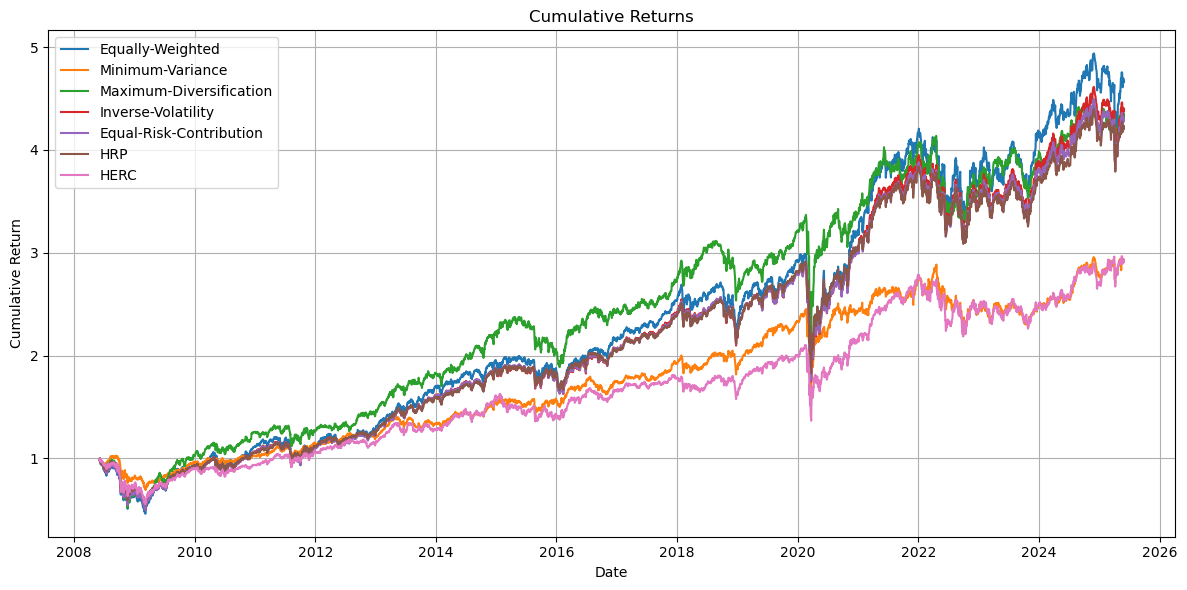

In [129]:
df_SP500_3jahre["Date"] = pd.to_datetime(df_SP500_3jahre["Date"])

#Date-Spalte als Index setzen
df_SP500_3jahre = df_SP500_3jahre.set_index("Date")

#Kumulierte Rendite berechnen (angenommen tägliche Returns)
#(1 + r).cumprod() - 1 ergibt den Gesamtzuwachs in Prozent
kumulative_returns = gesamt_return(df_SP500_3jahre)

#Plot
plt.figure(figsize=(12,6))
plt.plot(kumulative_returns)
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(kumulative_returns.columns, loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [130]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
sharpe_jahresweise_3jahre = df_SP500_3jahre.groupby(df_SP500_3jahre.index.year).apply(lambda x: x.apply(lambda y: sharpe_ratio(y) * np.sqrt(252)))

sharpe_jahresweise_3jahre

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -1.044174         -0.845529                -1.292886   
2009          1.175885          1.055808                 1.775505   
2010          0.978830          0.692061                 1.309103   
2011          0.096813          0.887335                 0.118085   
2012          1.156525          0.623833                 1.218063   
2013          2.496679          1.201740                 2.000969   
2014          1.117727          1.537576                 1.590008   
2015         -0.191445          0.210276                -0.440787   
2016          1.074551          1.167843                 1.350185   
2017          2.412124          1.621479                 1.432926   
2018         -0.520984         -0.024011                -0.088110   
2019          1.964304          2.421015                 1.896713   
2020          0.445700          0.288407                 0.319368   
2021          1.937052          1.182138                 1.542277   
2022         -0.426411         -0.702687                -0.467997   
2023          0.965277          0.295983                 0.879565   
2024          0.953661          1.422492                 0.719872   
2025          0.217672          1.011676                 0.629100   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2008           -1.037523                -1.077375 -1.021696 -0.787812  
2009            1.126409                 1.152666  1.131924  0.868125  
2010            0.946067                 0.946103  0.911388  0.367181  
2011            0.242770                 0.254476  0.393555  0.925626  
2012            1.103819                 1.121675  1.099365  0.713983  
2013            2.450160                 2.475255  2.453521  1.140994  
2014            1.263971                 1.326848  1.449447  1.744890  
2015           -0.118250                -0.141175 -0.030271 -0.588362  
2016            1.035111                 1.042034  0.958725  1.394029  
2017            2.500886                 2.465756  2.545285  1.176177  
2018           -0.482799                -0.417935 -0.385537 -0.600378  
2019            2.094446                 2.083112  2.264501  2.223173  
2020            0.420934                 0.408588  0.413813  0.392225  
2021            2.022202                 2.054208  2.029442  2.422280  
2022           -0.443763                -0.433406 -0.451829 -0.541193  
2023            0.876033                 0.840303  0.736658  0.223519  
2024            1.050949                 1.023330  1.075319  0.859744  
2025            0.306715                 0.350891  0.443491  1.245120

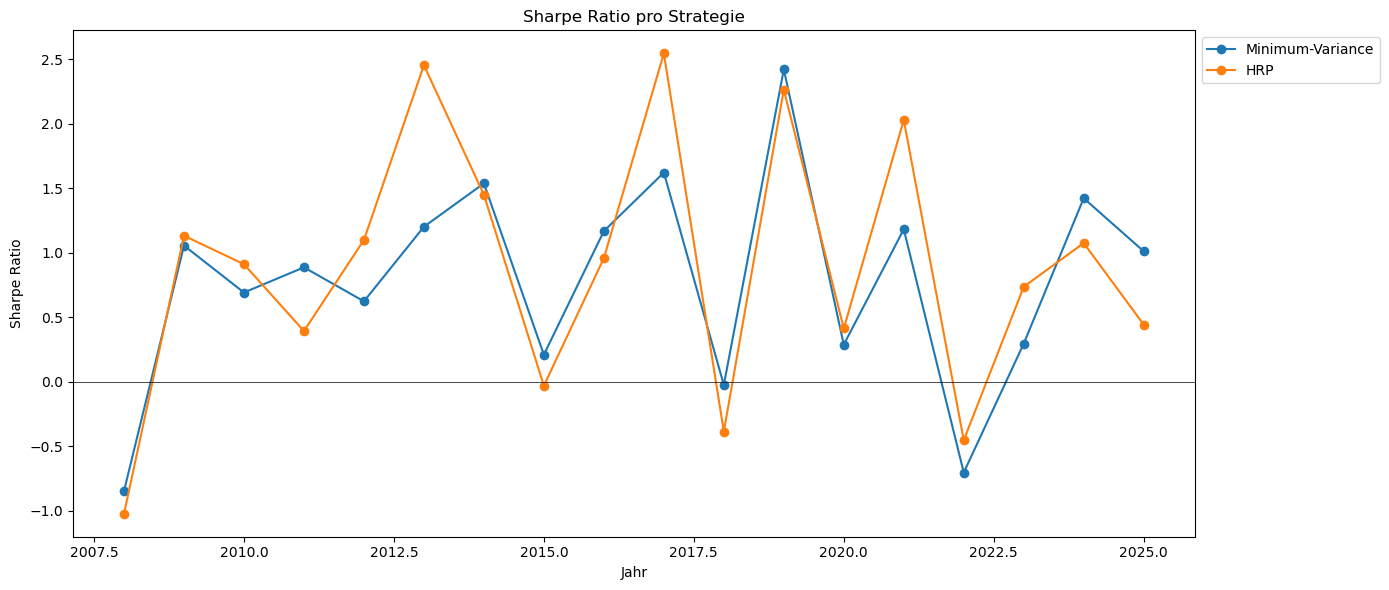

In [131]:
#Plotten der SR
strategien = sharpe_jahresweise_3jahre.columns
years = sharpe_jahresweise_3jahre.index

plt.figure(figsize=(14,6))

strategie = "Minimum-Variance"
plt.plot(years, sharpe_jahresweise_3jahre[strategie], label=strategie, marker='o')

strategie = "HRP"
plt.plot(years, sharpe_jahresweise_3jahre[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  
plt.xlabel("Jahr")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [132]:
#Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
def sharpe_total_3jahre(returns_daily):
    mean_daily = returns_daily.mean()
    std_daily = returns_daily.std()
    return (mean_daily / std_daily) * np.sqrt(4277)  # 252 Handelstage

gesamt_sharpe_3jahre = df_SP500_3jahre.apply(sharpe_total_3jahre)

print(gesamt_sharpe_3jahre)

Equally-Weighted           2.160403
Minimum-Variance           2.131743
Maximum-Diversification    2.320634
Inverse-Volatility         2.202835
Equal-Risk-Contribution    2.203186
HRP                        2.305862
HERC                       1.805219
dtype: float64


In [133]:
#Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
def sharpe_annual_3jahre(returns_daily):
    mean_daily = returns_daily.mean()
    std_daily = returns_daily.std()
    return (mean_daily / std_daily) * np.sqrt(252)  # 252 Handelstage

annualized_sharpe_3jahre = df_SP500_3jahre.apply(sharpe_annual_3jahre)

print(annualized_sharpe_3jahre)

Equally-Weighted           0.524403
Minimum-Variance           0.517447
Maximum-Diversification    0.563297
Inverse-Volatility         0.534703
Equal-Risk-Contribution    0.534788
HRP                        0.559711
HERC                       0.438188
dtype: float64


In [134]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
sortino_jahresweise_3jahre = df_SP500_3jahre.groupby(df_SP500_3jahre.index.year).apply(lambda x: x.apply(lambda y: sortino_ratio(y) * np.sqrt(252)))

sortino_jahresweise_3jahre

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -1.421619         -1.197739                -1.708987   
2009          1.754355          1.521372                 2.617365   
2010          1.417308          0.988985                 1.908452   
2011          0.131934          1.247571                 0.160562   
2012          1.752813          0.895674                 1.836822   
2013          3.748879          1.756521                 2.961670   
2014          1.558024          2.320073                 2.346150   
2015         -0.264734          0.292554                -0.597617   
2016          1.526508          1.693520                 2.046081   
2017          3.782465          2.445447                 2.144402   
2018         -0.676873         -0.031486                -0.123265   
2019          2.823678          3.608437                 2.636494   
2020          0.611452          0.394932                 0.423461   
2021          2.901263          1.815053                 2.355873   
2022         -0.598693         -0.923946                -0.635896   
2023          1.441548          0.411022                 1.289335   
2024          1.356418          2.158137                 1.046500   
2025          0.318849          1.391769                 0.900796   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2008           -1.421738                -1.473909 -1.412119 -1.112786  
2009            1.663696                 1.701984  1.662147  1.230362  
2010            1.365306                 1.363047  1.306154  0.522646  
2011            0.331570                 0.347374  0.537785  1.303685  
2012            1.665571                 1.691455  1.657181  1.088727  
2013            3.705508                 3.742410  3.733664  1.665562  
2014            1.781776                 1.874607  2.065356  2.612561  
2015           -0.163985                -0.195496 -0.042032 -0.776794  
2016            1.470344                 1.486414  1.364477  2.015104  
2017            3.946218                 3.878452  4.009737  1.718293  
2018           -0.624887                -0.543102 -0.498007 -0.774551  
2019            3.019907                 3.005182  3.307819  3.306278  
2020            0.575405                 0.555656  0.562334  0.550211  
2021            3.017723                 3.058593  3.001265  3.616551  
2022           -0.622520                -0.606616 -0.629425 -0.742301  
2023            1.297826                 1.242943  1.079278  0.317931  
2024            1.503595                 1.463670  1.539807  1.228082  
2025            0.446896                 0.510716  0.641276  1.800761

In [135]:
#Funktion für annualisierten Sharpe Ratio
def sortino_total_3jahre(returns_daily):
    zins_risikofrei = 0
    mean_daily = returns_daily.mean()
    temp = (np.minimum(0, returns_daily - zins_risikofrei))**2
    temp = np.mean(temp)
    downside_dev = np.sqrt(temp)
    return (mean_daily / downside_dev) * np.sqrt(4277)  # 252 Handelstage

#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
gesamt_sortino_3jahre = df_SP500_3jahre.apply(sortino_total_3jahre)

print(gesamt_sortino_3jahre)

Equally-Weighted           3.042032
Minimum-Variance           2.988087
Maximum-Diversification    3.223849
Inverse-Volatility         3.093796
Equal-Risk-Contribution    3.088794
HRP                        3.230989
HERC                       2.546918
dtype: float64


In [136]:
#Funktion für annualisierten Sharpe Ratio
def sortino_annual_3jahre(returns_daily):
    zins_risikofrei = 0
    mean_daily = returns_daily.mean()
    temp = (np.minimum(0, returns_daily - zins_risikofrei))**2
    temp = np.mean(temp)
    downside_dev = np.sqrt(temp)
    return (mean_daily / downside_dev) * np.sqrt(252)  # 252 Handelstage

#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
annualized_sortino_3jahre = df_SP500_3jahre.apply(sortino_annual_3jahre)

print(annualized_sortino_3jahre)

Equally-Weighted           0.738405
Minimum-Variance           0.725310
Maximum-Diversification    0.782538
Inverse-Volatility         0.750969
Equal-Risk-Contribution    0.749755
HRP                        0.784271
HERC                       0.618224
dtype: float64


In [137]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
max_drawdown_jahresweise_3jahre = df_SP500_3jahre.groupby(df_SP500_3jahre.index.year).apply(lambda x: x.apply(maximum_drawdown))

max_drawdown_jahresweise_3jahre

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -0.490979         -0.258299                -0.483142   
2009         -0.333670         -0.167429                -0.237614   
2010         -0.166424         -0.059711                -0.097812   
2011         -0.227913         -0.113956                -0.154381   
2012         -0.107332         -0.055537                -0.067304   
2013         -0.063807         -0.084765                -0.063436   
2014         -0.076533         -0.047369                -0.066760   
2015         -0.126512         -0.093150                -0.158669   
2016         -0.095306         -0.096479                -0.071306   
2017         -0.028651         -0.040507                -0.036729   
2018         -0.197399         -0.112879                -0.186131   
2019         -0.073355         -0.041461                -0.071862   
2020         -0.404247         -0.346238                -0.356402   
2021         -0.062110         -0.066287                -0.088258   
2022         -0.217543         -0.212373                -0.230966   
2023         -0.133119         -0.095378                -0.120865   
2024         -0.072814         -0.064371                -0.068804   
2025         -0.159728         -0.073694                -0.097456   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2008           -0.452171                -0.455914 -0.406987 -0.367341  
2009           -0.300806                -0.296166 -0.266721 -0.279099  
2010           -0.146812                -0.143473 -0.126768 -0.100870  
2011           -0.190376                -0.186233 -0.161359 -0.124365  
2012           -0.086664                -0.082174 -0.065122 -0.071970  
2013           -0.062937                -0.062590 -0.061694 -0.088939  
2014           -0.066926                -0.064545 -0.057527 -0.087633  
2015           -0.117132                -0.118219 -0.106704 -0.163708  
2016           -0.084600                -0.082379 -0.074011 -0.079668  
2017           -0.027246                -0.024553 -0.023119 -0.038189  
2018           -0.183793                -0.178980 -0.171752 -0.126543  
2019           -0.062661                -0.060501 -0.051130 -0.034436  
2020           -0.394676                -0.389345 -0.373261 -0.350091  
2021           -0.056355                -0.055008 -0.054920 -0.045383  
2022           -0.208549                -0.201860 -0.196070 -0.214801  
2023           -0.127879                -0.125937 -0.120126 -0.113573  
2024           -0.072908                -0.073040 -0.070341 -0.084616  
2025           -0.140866                -0.131706 -0.117477 -0.098235

In [138]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
max_drawdown_total_3jahre = df_SP500_3jahre.apply(maximum_drawdown)

max_drawdown_total_3jahre.info

<bound method Series.info of Equally-Weighted          -0.537822
Minimum-Variance          -0.346238
Maximum-Diversification   -0.483142
Inverse-Volatility        -0.499843
Equal-Risk-Contribution   -0.499946
HRP                       -0.453877
HERC                      -0.447729
dtype: float64>

In [139]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
calmar_jahresweise_3jahre = df_SP500_3jahre.groupby(df_SP500_3jahre.index.year).apply(lambda x: x.apply(calmar_ratio_total))

calmar_jahresweise_3jahre

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -0.698375         -0.670196                -0.697474   
2009          1.247551          0.950209                 2.282614   
2010          1.156759          1.205173                 2.352260   
2011         -0.035465          1.036437                 0.027637   
2012          1.482914          0.796391                 2.046777   
2013          5.287660          1.422910                 4.334741   
2014          1.692908          2.944111                 3.008066   
2015         -0.320427          0.201698                -0.472817   
2016          1.634860          1.210422                 2.629025   
2017          6.402472          2.513392                 3.385210   
2018         -0.445649         -0.086004                -0.116187   
2019          3.643536          5.525557                 2.936008   
2020          0.253104          0.121478                 0.145080   
2021          4.693360          1.873652                 2.202994   
2022         -0.523419         -0.549832                -0.492115   
2023          0.990555          0.250228                 0.798297   
2024          1.474327          1.887584                 0.973937   
2025          0.060404          0.766439                 0.385121   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2008           -0.694465                -0.697731 -0.681062 -0.707183  
2009            1.096690                 1.129014  1.038698  0.753681  
2010            1.126013                 1.135490  1.109283  0.427463  
2011            0.155915                 0.173616  0.374931  1.184757  
2012            1.533175                 1.606684  1.737884  0.878680  
2013            4.896625                 4.919895  4.660995  1.478598  
2014            2.080041                 2.255423  2.653288  2.494994  
2015           -0.242734                -0.267612 -0.137859 -0.616161  
2016            1.642578                 1.681675  1.602939  2.194222  
2017            6.526815                 6.992142  7.377395  1.958161  
2018           -0.426851                -0.380930 -0.360796 -0.629532  
2019            4.252405                 4.202942  5.158188  6.471479  
2020            0.230763                 0.219861  0.232360  0.223782  
2021            4.968853                 4.943969  4.565887  6.277148  
2022           -0.528711                -0.523205 -0.526230 -0.570457  
2023            0.867508                 0.811630  0.694146  0.176257  
2024            1.534820                 1.435998  1.483411  0.967381  
2025            0.124567                 0.159714  0.232959  0.899278

In [140]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
calmar_total_2_3jahre = df_SP500_3jahre.apply(calmar_ratio_total)

calmar_total_2_3jahre.info

<bound method Series.info of Equally-Weighted           6.820032
Minimum-Variance           5.584650
Maximum-Diversification    6.937156
Inverse-Volatility         6.783701
Equal-Risk-Contribution    6.592266
HRP                        7.110067
HERC                       4.316918
dtype: float64>

In [141]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
var_jahresweise_3jahre = df_SP500_3jahre.groupby(df_SP500_3jahre.index.year).apply(lambda x: x.apply(value_at_risk_func))

var_jahresweise_3jahre

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -0.058968         -0.032262                -0.059999   
2009         -0.034520         -0.016084                -0.026852   
2010         -0.019367         -0.011488                -0.017399   
2011         -0.027221         -0.011914                -0.018636   
2012         -0.013006         -0.007017                -0.009700   
2013         -0.012173         -0.009594                -0.012302   
2014         -0.012178         -0.008084                -0.012384   
2015         -0.015891         -0.012118                -0.015827   
2016         -0.015179         -0.010022                -0.012318   
2017         -0.006205         -0.006237                -0.009042   
2018         -0.019412         -0.012156                -0.014606   
2019         -0.012303         -0.008261                -0.009441   
2020         -0.035437         -0.021568                -0.025077   
2021         -0.013548         -0.009328                -0.011573   
2022         -0.023237         -0.016364                -0.022746   
2023         -0.014080         -0.009879                -0.011426   
2024         -0.011127         -0.007776                -0.010691   
2025         -0.018869         -0.012179                -0.012865   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2008           -0.052582                -0.052068 -0.046060 -0.047735  
2009           -0.028874                -0.028557 -0.025058 -0.026275  
2010           -0.017671                -0.017430 -0.015865 -0.014483  
2011           -0.023335                -0.022969 -0.019672 -0.014579  
2012           -0.011327                -0.011155 -0.010383 -0.008620  
2013           -0.010856                -0.010577 -0.009726 -0.011218  
2014           -0.011013                -0.010791 -0.010507 -0.012390  
2015           -0.015880                -0.015643 -0.015042 -0.015446  
2016           -0.013710                -0.013541 -0.013546 -0.012375  
2017           -0.005985                -0.005723 -0.005631 -0.006765  
2018           -0.018670                -0.018176 -0.017629 -0.012699  
2019           -0.011001                -0.010637 -0.010042 -0.009065  
2020           -0.032344                -0.031414 -0.030160 -0.027986  
2021           -0.012419                -0.011863 -0.011797 -0.010280  
2022           -0.022422                -0.022201 -0.020633 -0.021076  
2023           -0.013693                -0.013173 -0.012659 -0.013009  
2024           -0.009788                -0.009563 -0.009247 -0.009475  
2025           -0.018131                -0.017792 -0.017251 -0.016148

In [142]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
var_total_3jahre = df_SP500_3jahre.apply(value_at_risk_func)

var_total_3jahre.info

<bound method Series.info of Equally-Weighted          -0.019719
Minimum-Variance          -0.012031
Maximum-Diversification   -0.016181
Inverse-Volatility        -0.018174
Equal-Risk-Contribution   -0.017764
HRP                       -0.016358
HERC                      -0.015428
dtype: float64>

In [143]:
monthly_returns_3jahre = df_SP500_3jahre.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_var_3jahre = monthly_returns_3jahre.apply(value_at_risk_func)

monthly_var_3jahre.info

<bound method Series.info of Equally-Weighted          -0.084087
Minimum-Variance          -0.051301
Maximum-Diversification   -0.062584
Inverse-Volatility        -0.070755
Equal-Risk-Contribution   -0.073858
HRP                       -0.064577
HERC                      -0.060388
dtype: float64>

In [144]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
es_jahresweise_3jahre = df_SP500_3jahre.groupby(df_SP500_3jahre.index.year).apply(lambda x: x.apply(expected_shortfall))

es_jahresweise_3jahre

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -0.077688         -0.045963                -0.070561   
2009         -0.048534         -0.020969                -0.036350   
2010         -0.029439         -0.015917                -0.024657   
2011         -0.038673         -0.019538                -0.028634   
2012         -0.018258         -0.009981                -0.013876   
2013         -0.016648         -0.013702                -0.017780   
2014         -0.017413         -0.011403                -0.016521   
2015         -0.022069         -0.018220                -0.022303   
2016         -0.021881         -0.013212                -0.016495   
2017         -0.009464         -0.008064                -0.011248   
2018         -0.025467         -0.018877                -0.020524   
2019         -0.019390         -0.012693                -0.016033   
2020         -0.062464         -0.051313                -0.053360   
2021         -0.019170         -0.013438                -0.015671   
2022         -0.031114         -0.023593                -0.030160   
2023         -0.017439         -0.012980                -0.013874   
2024         -0.016258         -0.010390                -0.013495   
2025         -0.032846         -0.019035                -0.020784   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2008           -0.070948                -0.070399 -0.062851 -0.069999  
2009           -0.041276                -0.040668 -0.034468 -0.039641  
2010           -0.026452                -0.026090 -0.023603 -0.021906  
2011           -0.034603                -0.034102 -0.030553 -0.023641  
2012           -0.016191                -0.015769 -0.013654 -0.010796  
2013           -0.015497                -0.015350 -0.014469 -0.015248  
2014           -0.016188                -0.016005 -0.015141 -0.015277  
2015           -0.021160                -0.021156 -0.020388 -0.024190  
2016           -0.020216                -0.019881 -0.018537 -0.017325  
2017           -0.008863                -0.008756 -0.008422 -0.008395  
2018           -0.024568                -0.023916 -0.023520 -0.020096  
2019           -0.018116                -0.017320 -0.016187 -0.013303  
2020           -0.060897                -0.059766 -0.057256 -0.053926  
2021           -0.018091                -0.017349 -0.016487 -0.015481  
2022           -0.029371                -0.028802 -0.027352 -0.029075  
2023           -0.016494                -0.015822 -0.015189 -0.015930  
2024           -0.014794                -0.014248 -0.013129 -0.013018  
2025           -0.030137                -0.029042 -0.026010 -0.024138

In [145]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
es_total_3jahre = df_SP500_3jahre.apply(expected_shortfall)

es_total_3jahre.info

<bound method Series.info of Equally-Weighted          -0.033880
Minimum-Variance          -0.020757
Maximum-Diversification   -0.028054
Inverse-Volatility        -0.030980
Equal-Risk-Contribution   -0.030414
HRP                       -0.027787
HERC                      -0.027618
dtype: float64>

In [146]:
monthly_returns_3jahre = df_SP500_3jahre.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_es_3jahre = monthly_returns_3jahre.apply(expected_shortfall)

monthly_es_3jahre.info

<bound method Series.info of Equally-Weighted          -0.114393
Minimum-Variance          -0.075630
Maximum-Diversification   -0.105366
Inverse-Volatility        -0.105494
Equal-Risk-Contribution   -0.104155
HRP                       -0.096080
HERC                      -0.093245
dtype: float64>

In [147]:
yearly_returns_3jahre = df_SP500_3jahre.resample('Y').apply(lambda x: (1 + x).prod() - 1)
yearly_es_3jahre  = yearly_returns_3jahre.apply(expected_shortfall)

yearly_es_3jahre.info

<bound method Series.info of Equally-Weighted          -0.342888
Minimum-Variance          -0.173111
Maximum-Diversification   -0.336979
Inverse-Volatility        -0.314017
Equal-Risk-Contribution   -0.318105
HRP                       -0.277183
HERC                      -0.259778
dtype: float64>

In [148]:
#Zusammenfassung der Metriken
Zusammenfassung_3jahre = pd.concat([annualized_sharpe_3jahre, annualized_sortino_3jahre, max_drawdown_total_3jahre, calmar_total_2_3jahre, monthly_var_3jahre, monthly_es_3jahre], axis=1)
Zusammenfassung_3jahre.columns = ["Sharpe","Sortino", "Max Drawdown", "Calmar", "Var", "ES"]
print(Zusammenfassung_3jahre)

                           Sharpe   Sortino  Max Drawdown    Calmar       Var  \
Equally-Weighted         0.524403  0.738405     -0.537822  6.820032 -0.084087   
Minimum-Variance         0.517447  0.725310     -0.346238  5.584650 -0.051301   
Maximum-Diversification  0.563297  0.782538     -0.483142  6.937156 -0.062584   
Inverse-Volatility       0.534703  0.750969     -0.499843  6.783701 -0.070755   
Equal-Risk-Contribution  0.534788  0.749755     -0.499946  6.592266 -0.073858   
HRP                      0.559711  0.784271     -0.453877  7.110067 -0.064577   
HERC                     0.438188  0.618224     -0.447729  4.316918 -0.060388   

                               ES  
Equally-Weighted        -0.114393  
Minimum-Variance        -0.075630  
Maximum-Diversification -0.105366  
Inverse-Volatility      -0.105494  
Equal-Risk-Contribution -0.104155  
HRP                     -0.096080  
HERC                    -0.093245  


## S&P500 3 Jahre Shrinked

In [149]:
#Bearbeitete SP500-Daten (Gesamtbestand, 3 Jahre)

df_SP500_3jahre_shrinked = pd.read_csv(
    'returnssp500shrinked_neu_3jahre_f.csv',
    sep=',',
    encoding='utf-8',
    index_col=0,
    decimal = '.',
    low_memory=False,
    parse_dates=['Date'],
    dayfirst=True
)

In [150]:
df_SP500_3jahre_shrinked.info

<bound method DataFrame.info of             Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0     2008-06-02         -0.012077         -0.007048                -0.009316   
1     2008-06-03         -0.003496         -0.001160                -0.001386   
2     2008-06-04          0.001884          0.001249                -0.002456   
3     2008-06-05          0.016044          0.006078                 0.013478   
4     2008-06-06         -0.035179         -0.023970                -0.029070   
...          ...               ...               ...                      ...   
4272  2025-05-23         -0.003277          0.001936                 0.000672   
4273  2025-05-27          0.018613          0.007390                 0.010399   
4274  2025-05-28         -0.009069         -0.007023                -0.007523   
4275  2025-05-29          0.003843          0.000673                 0.001833   
4276  2025-05-30         -0.000525          0.008350                 0.006729

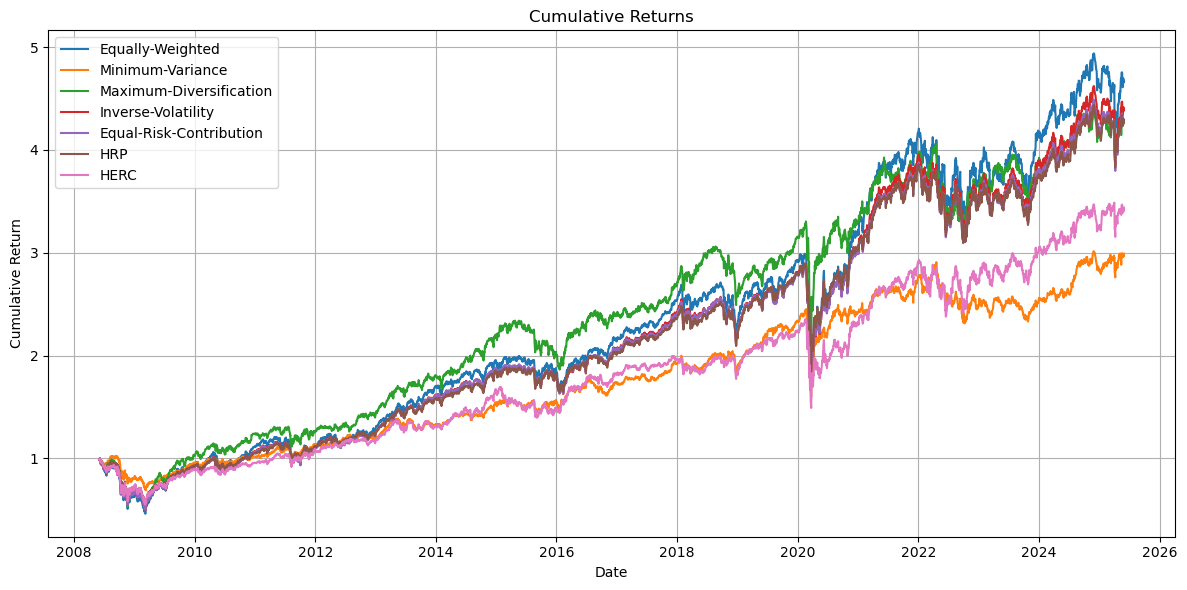

In [151]:
df_SP500_3jahre_shrinked["Date"] = pd.to_datetime(df_SP500_3jahre_shrinked["Date"])

#Date-Spalte als Index setzen
df_SP500_3jahre_shrinked = df_SP500_3jahre_shrinked.set_index("Date")

#Kumulierte Rendite berechnen (angenommen tägliche Returns)
#(1 + r).cumprod() - 1 ergibt den Gesamtzuwachs in Prozent
kumulative_returns = gesamt_return(df_SP500_3jahre_shrinked)

#Plot
plt.figure(figsize=(12,6))
plt.plot(kumulative_returns)
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(kumulative_returns.columns, loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [152]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
sharpe_jahresweise_3jahre_shrinked = df_SP500_3jahre_shrinked.groupby(df_SP500_3jahre_shrinked.index.year).apply(lambda x: x.apply(lambda y: sharpe_ratio(y) * np.sqrt(252)))

sharpe_jahresweise_3jahre_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -1.044174         -0.872875                -1.267179   
2009          1.175885          1.035513                 1.776831   
2010          0.978830          0.706638                 1.276768   
2011          0.096813          0.859956                 0.158975   
2012          1.156525          0.630246                 1.198898   
2013          2.496679          1.247847                 1.996931   
2014          1.117727          1.542103                 1.614596   
2015         -0.191445          0.196520                -0.440238   
2016          1.074551          1.183814                 1.356211   
2017          2.412124          1.747529                 1.408242   
2018         -0.520984         -0.045057                -0.096737   
2019          1.964304          2.471871                 1.895636   
2020          0.445700          0.269709                 0.310280   
2021          1.937052          1.327714                 1.564320   
2022         -0.426411         -0.627567                -0.429207   
2023          0.965277          0.271296                 0.843752   
2024          0.953661          1.419415                 0.747954   
2025          0.217672          1.000592                 0.616656   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2008           -1.038031                -1.077427 -1.027510 -0.805426  
2009            1.126799                 1.152975  1.129885  0.910979  
2010            0.947514                 0.946134  0.886742  0.617172  
2011            0.238028                 0.254200  0.390302  0.858478  
2012            1.105889                 1.121884  1.101529  0.817985  
2013            2.452486                 2.475237  2.429394  1.196542  
2014            1.260465                 1.323155  1.439067  1.872884  
2015           -0.120035                -0.141510 -0.041946 -0.521404  
2016            1.035436                 1.025596  0.947796  1.722852  
2017            2.499723                 2.465723  2.578836  1.251162  
2018           -0.484663                -0.417991 -0.368684 -0.477908  
2019            2.089685                 2.083169  2.287579  2.191417  
2020            0.423612                 0.411305  0.431925  0.282870  
2021            2.019177                 2.052137  2.072069  1.986822  
2022           -0.443880                -0.435053 -0.457435 -0.192195  
2023            0.878575                 0.840185  0.764759  0.861159  
2024            1.049341                 1.023314  1.122073  0.768099  
2025            0.304963                 0.350846  0.485650  0.938180

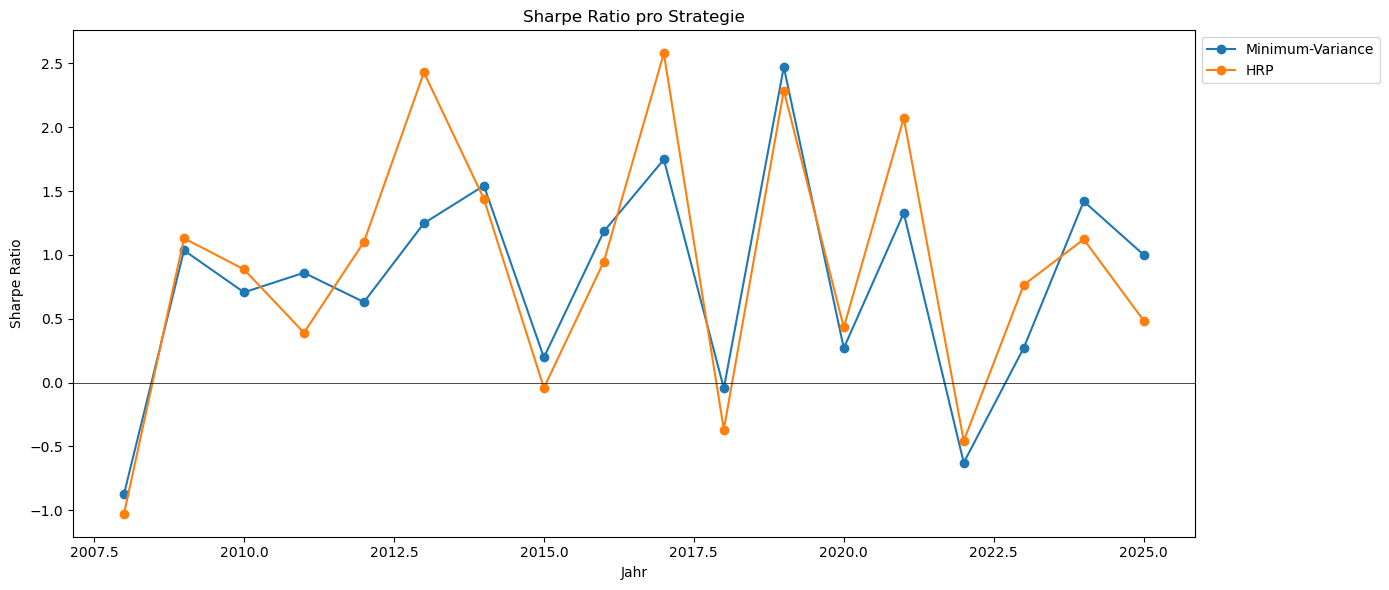

In [153]:
#Plotten der SR
strategien = sharpe_jahresweise_3jahre_shrinked.columns
years = sharpe_jahresweise_3jahre_shrinked.index

plt.figure(figsize=(14,6))

strategie = "Minimum-Variance"
plt.plot(years, sharpe_jahresweise_3jahre_shrinked[strategie], label=strategie, marker='o')

strategie = "HRP"
plt.plot(years, sharpe_jahresweise_3jahre_shrinked[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  
plt.xlabel("Jahr")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [154]:
gesamt_sharpe_3jahre_shrinked = df_SP500_3jahre_shrinked.apply(sharpe_annual_3jahre)

print(gesamt_sharpe_3jahre_shrinked)

Equally-Weighted           0.524403
Minimum-Variance           0.526443
Maximum-Diversification    0.566583
Inverse-Volatility         0.534051
Equal-Risk-Contribution    0.534186
HRP                        0.564452
HERC                       0.480897
dtype: float64


In [155]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
sortino_jahresweise_3jahre_shrinked = df_SP500_3jahre_shrinked.groupby(df_SP500_3jahre_shrinked.index.year).apply(lambda x: x.apply(lambda y: sortino_ratio(y) * np.sqrt(252)))

sortino_jahresweise_3jahre_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -1.421619         -1.232985                -1.678699   
2009          1.754355          1.486516                 2.618542   
2010          1.417308          1.010793                 1.857591   
2011          0.131934          1.204788                 0.216092   
2012          1.752813          0.907699                 1.808792   
2013          3.748879          1.821924                 2.959081   
2014          1.558024          2.326218                 2.384747   
2015         -0.264734          0.273142                -0.596631   
2016          1.526508          1.717686                 2.056806   
2017          3.782465          2.655380                 2.104093   
2018         -0.676873         -0.058952                -0.135164   
2019          2.823678          3.687445                 2.637576   
2020          0.611452          0.367855                 0.411276   
2021          2.901263          2.032705                 2.388416   
2022         -0.598693         -0.826537                -0.583505   
2023          1.441548          0.376288                 1.231259   
2024          1.356418          2.150459                 1.089319   
2025          0.318849          1.375070                 0.881557   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2008           -1.422002                -1.473971 -1.418861 -1.130424  
2009            1.664653                 1.702472  1.659597  1.299535  
2010            1.367557                 1.363096  1.271681  0.868475  
2011            0.325064                 0.346997  0.533392  1.211878  
2012            1.668967                 1.691848  1.661515  1.255407  
2013            3.708627                 3.742370  3.694959  1.764944  
2014            1.776273                 1.869217  2.050839  2.853406  
2015           -0.166448                -0.195957 -0.058247 -0.684043  
2016            1.470747                 1.459584  1.346904  2.514008  
2017            3.944052                 3.878395  4.073993  1.829930  
2018           -0.627352                -0.543173 -0.477102 -0.617237  
2019            3.012479                 3.005304  3.343142  3.235378  
2020            0.579258                 0.559537  0.588547  0.389572  
2021            3.013853                 3.054525  3.070805  2.953923  
2022           -0.622706                -0.608941 -0.637406 -0.270383  
2023            1.301800                 1.242512  1.123727  1.283356  
2024            1.501185                 1.463646  1.607435  1.114970  
2025            0.444416                 0.510651  0.703526  1.321759

In [156]:
#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
gesamt_sortino_3jahre_shrinked = df_SP500_3jahre_shrinked.apply(sortino_annual_3jahre)

print(gesamt_sortino_3jahre_shrinked)

Equally-Weighted           0.738405
Minimum-Variance           0.736384
Maximum-Diversification    0.786902
Inverse-Volatility         0.750115
Equal-Risk-Contribution    0.748913
HRP                        0.791552
HERC                       0.676892
dtype: float64


In [157]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
max_drawdown_jahresweise_3jahre_shrinked = df_SP500_3jahre_shrinked.groupby(df_SP500_3jahre_shrinked.index.year).apply(lambda x: x.apply(maximum_drawdown))

max_drawdown_jahresweise_3jahre_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -0.490979         -0.263348                -0.466540   
2009         -0.333670         -0.167665                -0.226243   
2010         -0.166424         -0.060988                -0.094927   
2011         -0.227913         -0.114961                -0.149289   
2012         -0.107332         -0.054290                -0.064875   
2013         -0.063807         -0.082518                -0.062999   
2014         -0.076533         -0.045678                -0.065679   
2015         -0.126512         -0.092411                -0.157356   
2016         -0.095306         -0.094267                -0.071584   
2017         -0.028651         -0.039571                -0.037104   
2018         -0.197399         -0.112923                -0.185864   
2019         -0.073355         -0.039722                -0.070426   
2020         -0.404247         -0.347526                -0.356089   
2021         -0.062110         -0.059877                -0.084254   
2022         -0.217543         -0.204253                -0.221404   
2023         -0.133119         -0.094994                -0.120880   
2024         -0.072814         -0.064315                -0.068309   
2025         -0.159728         -0.073996                -0.096847   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2008           -0.454430                -0.455955 -0.407433 -0.416437  
2009           -0.302288                -0.296194 -0.266627 -0.261660  
2010           -0.147474                -0.143485 -0.126300 -0.084885  
2011           -0.191658                -0.186254 -0.161333 -0.123085  
2012           -0.087085                -0.082180 -0.064576 -0.062617  
2013           -0.062933                -0.062590 -0.061466 -0.084709  
2014           -0.067167                -0.064543 -0.055341 -0.081274  
2015           -0.117367                -0.118240 -0.107970 -0.176033  
2016           -0.084859                -0.082379 -0.074839 -0.066241  
2017           -0.027303                -0.024554 -0.022811 -0.039044  
2018           -0.184298                -0.178984 -0.170681 -0.114231  
2019           -0.063037                -0.060500 -0.052459 -0.036836  
2020           -0.394916                -0.389341 -0.372485 -0.366695  
2021           -0.056581                -0.055012 -0.055147 -0.049426  
2022           -0.209034                -0.202267 -0.196368 -0.188561  
2023           -0.127989                -0.125810 -0.120275 -0.102057  
2024           -0.072923                -0.073040 -0.069275 -0.075849  
2025           -0.141277                -0.131712 -0.116270 -0.095306

In [158]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
max_drawdown_total_3jahre_shrinked = df_SP500_3jahre_shrinked.apply(maximum_drawdown)

max_drawdown_total_3jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.537822
Minimum-Variance          -0.347526
Maximum-Diversification   -0.466540
Inverse-Volatility        -0.501700
Equal-Risk-Contribution   -0.499981
HRP                       -0.453840
HERC                      -0.449686
dtype: float64>

In [159]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
calmar_jahresweise_3jahre_shrinked = df_SP500_3jahre_shrinked.groupby(df_SP500_3jahre_shrinked.index.year).apply(lambda x: x.apply(calmar_ratio_total))

calmar_jahresweise_3jahre_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -0.698375         -0.673810                -0.693204   
2009          1.247551          0.918504                 2.259569   
2010          1.156759          1.203241                 2.268420   
2011         -0.035465          0.990598                 0.082295   
2012          1.482914          0.821764                 2.040145   
2013          5.287660          1.518937                 4.272600   
2014          1.692908          3.051236                 3.053466   
2015         -0.320427          0.184064                -0.474231   
2016          1.634860          1.256756                 2.618829   
2017          6.402472          2.773754                 3.256029   
2018         -0.445649         -0.107046                -0.121812   
2019          3.643536          5.911907                 2.966928   
2020          0.253104          0.103879                 0.136674   
2021          4.693360          2.334384                 2.309648   
2022         -0.523419         -0.517038                -0.469960   
2023          0.990555          0.224994                 0.754603   
2024          1.474327          1.882397                 1.016313   
2025          0.060404          0.757701                 0.378060   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2008           -0.694286                -0.697733 -0.680941 -0.663938  
2009            1.099642                 1.129536  1.039131  0.857686  
2010            1.127223                 1.135509  1.077276  0.922666  
2011            0.149102                 0.173257  0.369409  1.088499  
2012            1.533295                 1.607210  1.755581  1.163163  
2013            4.908554                 4.919962  4.620157  1.601600  
2014            2.069548                 2.248172  2.710607  2.895591  
2015           -0.244696                -0.267985 -0.152027 -0.524672  
2016            1.640660                 1.658244  1.568464  3.474307  
2017            6.521546                 6.991926  7.581751  2.066045  
2018           -0.427772                -0.380966 -0.351238 -0.569488  
2019            4.227384                 4.203271  5.069606  6.009394  
2020            0.233511                 0.222701  0.251482  0.101451  
2021            4.959221                 4.942155  4.663223  5.031322  
2022           -0.528995                -0.524268 -0.533968 -0.328054  
2023            0.871151                 0.812870  0.723543  1.027115  
2024            1.533891                 1.436004  1.584431  0.971620  
2025            0.123213                 0.159680  0.265425  0.649645

In [160]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
calmar_total_2_3jahre_shrinked = df_SP500_3jahre_shrinked.apply(calmar_ratio_total)

calmar_total_2_3jahre_shrinked.info

<bound method Series.info of Equally-Weighted           6.820032
Minimum-Variance           5.725426
Maximum-Diversification    7.048346
Inverse-Volatility         6.772611
Equal-Risk-Contribution    6.578603
HRP                        7.244262
HERC                       5.422129
dtype: float64>

In [161]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
var_jahresweise_3jahre_shrinked = df_SP500_3jahre_shrinked.groupby(df_SP500_3jahre_shrinked.index.year).apply(lambda x: x.apply(value_at_risk_func))

var_jahresweise_3jahre_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -0.058968         -0.032514                -0.057810   
2009         -0.034520         -0.015615                -0.025699   
2010         -0.019367         -0.011485                -0.016776   
2011         -0.027221         -0.011945                -0.018195   
2012         -0.013006         -0.007155                -0.009550   
2013         -0.012173         -0.009601                -0.012020   
2014         -0.012178         -0.007986                -0.012073   
2015         -0.015891         -0.012197                -0.015729   
2016         -0.015179         -0.009954                -0.012253   
2017         -0.006205         -0.006129                -0.009012   
2018         -0.019412         -0.012132                -0.014526   
2019         -0.012303         -0.008307                -0.009325   
2020         -0.035437         -0.021715                -0.024516   
2021         -0.013548         -0.009436                -0.011586   
2022         -0.023237         -0.016332                -0.022086   
2023         -0.014080         -0.009865                -0.011367   
2024         -0.011127         -0.007701                -0.010689   
2025         -0.018869         -0.012271                -0.012945   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2008           -0.052926                -0.052073 -0.046264 -0.054257  
2009           -0.029062                -0.028561 -0.025084 -0.025896  
2010           -0.017735                -0.017431 -0.015788 -0.014100  
2011           -0.023468                -0.022971 -0.019579 -0.014585  
2012           -0.011354                -0.011155 -0.010233 -0.008594  
2013           -0.010870                -0.010577 -0.009625 -0.010376  
2014           -0.011020                -0.010790 -0.010645 -0.011581  
2015           -0.015890                -0.015643 -0.015120 -0.016646  
2016           -0.013721                -0.013541 -0.013672 -0.012346  
2017           -0.005988                -0.005723 -0.005595 -0.006765  
2018           -0.018694                -0.018176 -0.017428 -0.012102  
2019           -0.011042                -0.010638 -0.010045 -0.009042  
2020           -0.032471                -0.031415 -0.030197 -0.029122  
2021           -0.012444                -0.011863 -0.011595 -0.011593  
2022           -0.022463                -0.022228 -0.020699 -0.022666  
2023           -0.013714                -0.013242 -0.012537 -0.013003  
2024           -0.009811                -0.009563 -0.009524 -0.009238  
2025           -0.018170                -0.017792 -0.017045 -0.015600

In [162]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
var_total_3jahre_shrinked = df_SP500_3jahre_shrinked.apply(value_at_risk_func)

var_total_3jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.019719
Minimum-Variance          -0.011945
Maximum-Diversification   -0.015855
Inverse-Volatility        -0.018224
Equal-Risk-Contribution   -0.017765
HRP                       -0.016401
HERC                      -0.015701
dtype: float64>

In [163]:
monthly_returns_3jahre_shrinked = df_SP500_3jahre_shrinked.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_var_3jahre_shrinked = monthly_returns_3jahre_shrinked.apply(value_at_risk_func)

monthly_var_3jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.084087
Minimum-Variance          -0.050834
Maximum-Diversification   -0.059167
Inverse-Volatility        -0.071150
Equal-Risk-Contribution   -0.073870
HRP                       -0.063929
HERC                      -0.062463
dtype: float64>

In [164]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
es_jahresweise_3jahre_shrinked = df_SP500_3jahre_shrinked.groupby(df_SP500_3jahre_shrinked.index.year).apply(lambda x: x.apply(expected_shortfall))

es_jahresweise_3jahre_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -0.077688         -0.046080                -0.068587   
2009         -0.048534         -0.020771                -0.034490   
2010         -0.029439         -0.015775                -0.023825   
2011         -0.038673         -0.019689                -0.028033   
2012         -0.018258         -0.009912                -0.013600   
2013         -0.016648         -0.013701                -0.017386   
2014         -0.017413         -0.011373                -0.016213   
2015         -0.022069         -0.018220                -0.022269   
2016         -0.021881         -0.013238                -0.016384   
2017         -0.009464         -0.007975                -0.011177   
2018         -0.025467         -0.018876                -0.020453   
2019         -0.019390         -0.012758                -0.015898   
2020         -0.062464         -0.051347                -0.053273   
2021         -0.019170         -0.013356                -0.015488   
2022         -0.031114         -0.023472                -0.029561   
2023         -0.017439         -0.012992                -0.013836   
2024         -0.016258         -0.010389                -0.013390   
2025         -0.032846         -0.019146                -0.020791   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2008           -0.071289                -0.070403 -0.062678 -0.074709  
2009           -0.041580                -0.040677 -0.034557 -0.038986  
2010           -0.026549                -0.026091 -0.023566 -0.021171  
2011           -0.034741                -0.034105 -0.030456 -0.023448  
2012           -0.016235                -0.015771 -0.013702 -0.010856  
2013           -0.015519                -0.015350 -0.014419 -0.014795  
2014           -0.016219                -0.016005 -0.015028 -0.014894  
2015           -0.021177                -0.021157 -0.020417 -0.024755  
2016           -0.020253                -0.020009 -0.018617 -0.017829  
2017           -0.008878                -0.008756 -0.008437 -0.008539  
2018           -0.024600                -0.023916 -0.023571 -0.019686  
2019           -0.018161                -0.017321 -0.016209 -0.013593  
2020           -0.060961                -0.059802 -0.057131 -0.058538  
2021           -0.018137                -0.017377 -0.016484 -0.016862  
2022           -0.029445                -0.028838 -0.027572 -0.028622  
2023           -0.016523                -0.015850 -0.015063 -0.015740  
2024           -0.014822                -0.014249 -0.013238 -0.013113  
2025           -0.030205                -0.029043 -0.026147 -0.022912

In [165]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
es_total_3jahre_shrinked = df_SP500_3jahre_shrinked.apply(expected_shortfall)

es_total_3jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.033880
Minimum-Variance          -0.020728
Maximum-Diversification   -0.027397
Inverse-Volatility        -0.031094
Equal-Risk-Contribution   -0.030431
HRP                       -0.027791
HERC                      -0.028411
dtype: float64>

In [166]:
monthly_returns_3jahre_shrinked = df_SP500_3jahre_shrinked.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_es_3jahre_shrinked = monthly_returns_3jahre_shrinked.apply(expected_shortfall)

monthly_es_3jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.114393
Minimum-Variance          -0.076225
Maximum-Diversification   -0.101952
Inverse-Volatility        -0.105875
Equal-Risk-Contribution   -0.104188
HRP                       -0.095733
HERC                      -0.093168
dtype: float64>

In [167]:
yearly_returns_3jahre_shrinked = df_SP500_3jahre_shrinked.resample('Y').apply(lambda x: (1 + x).prod() - 1)
yearly_es_3jahre_shrinked  = yearly_returns_3jahre_shrinked.apply(expected_shortfall)

yearly_es_3jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.342888
Minimum-Variance          -0.177446
Maximum-Diversification   -0.323407
Inverse-Volatility        -0.315505
Equal-Risk-Contribution   -0.318135
HRP                       -0.277438
HERC                      -0.276488
dtype: float64>

In [168]:
#Zusammenfassung der Metriken
Zusammenfassung_3jahre_shrinked = pd.concat([gesamt_sharpe_3jahre_shrinked, gesamt_sortino_3jahre_shrinked, max_drawdown_total_3jahre_shrinked, calmar_total_2_3jahre_shrinked, monthly_var_3jahre_shrinked, monthly_es_3jahre_shrinked], axis=1)
Zusammenfassung_3jahre_shrinked.columns = ["Sharpe","Sortino", "Max Drawdown", "Calmar", "Var", "ES"]
print(Zusammenfassung_3jahre_shrinked)

                           Sharpe   Sortino  Max Drawdown    Calmar       Var  \
Equally-Weighted         0.524403  0.738405     -0.537822  6.820032 -0.084087   
Minimum-Variance         0.526443  0.736384     -0.347526  5.725426 -0.050834   
Maximum-Diversification  0.566583  0.786902     -0.466540  7.048346 -0.059167   
Inverse-Volatility       0.534051  0.750115     -0.501700  6.772611 -0.071150   
Equal-Risk-Contribution  0.534186  0.748913     -0.499981  6.578603 -0.073870   
HRP                      0.564452  0.791552     -0.453840  7.244262 -0.063929   
HERC                     0.480897  0.676892     -0.449686  5.422129 -0.062463   

                               ES  
Equally-Weighted        -0.114393  
Minimum-Variance        -0.076225  
Maximum-Diversification -0.101952  
Inverse-Volatility      -0.105875  
Equal-Risk-Contribution -0.104188  
HRP                     -0.095733  
HERC                    -0.093168  
